<a href="https://colab.research.google.com/github/i544c/visualizacaodainformacao/blob/main/WSNASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## **TECNOLOGIA EM CIÊNCIA DE DADOS**

---
<H3><b>Disciplina: Visualização da Informação - Turma 001</b>


**Tutor:**
- Prof. Cayro de Macêdo Mendes

**Discente:**
- Isaac Gomes Veras

---
**PROJETO DE DISCIPLINA**

---

<H2><center><b> WSNASA - Visualização do Dataset </b></center>
<H4><center><b> EDA dos Dados Eólicos Offshore para o Litoral Paraibano</b></center>


---

 - **Link para o [COLAB]('https://colab.research.google.com/drive/1MlHg5Vbi8VLHGBtEHPcEZMNt4HlnJbGs?usp=sharing')**
 - A próxima célula abordará o contexto no qual o estudo está inserido.

---
---
<div style="text-align:center">
  <img src="https://novoportal.cruzeirodosul.edu.br/static/logos/16/logo-negativo_16.svg" width="120">
  <H2><center><b>UNIVERSIDADE CRUZEIRO DO SUL</center>
</div>



1. **INTRODUÇÃO:**

 ><b>Contexto Ambiental:</b></br>
     A energia eólica é uma das fontes renováveis mais promissoras para a diversificação da matriz energética brasileira, especialmente em regiões de clima litorâneo, como em João Pessoa, capital da Paraíba. </br>No entanto, a análise e o planejamento de projetos eólicos dependem fortemente da disponibilidade de dados confiáveis sobre a velocidade de ventos offshore.</br>
 </br><b>Contexto Socioeconômico:</b></br>
     Outro aspecto importante é a análise de viabilidade econômica em projetos eólicos, que depende criticamente de dados precisos e contínuos sobre a velocidade do vento, pois permitem estimar o potencial energético e otimizar o retorno financeiro. </br>No entanto, a escassez de dados confiáveis e padronizados dificulta o planejamento estratégico e a atração de investimentos.</br>
 </br><b>Desafios:</b></br>
     Atualmente, um dos principais desafios enfrentados por pesquisadores e formuladores de políticas públicas é a dificuldade de acesso a dados de velocidade do vento nacionais de qualidade.
     </br>Os bancos de dados ambientais brasileiros são, em sua maioria, descentralizados,com formatos variados, lacunas temporais e dificuldades de integração. Além disso, muitas vezes esses dados estão organizados de forma semiestruturada, exigindo tratamento extensivo antes de sua aplicação em análises mais robustas.</br>
 </br><b>Objetivo:</b></br>
     Este projeto propõe o uso de dados diários de velocidade do vento (`50m altitude`) oriundos da Base de Dados (BD) **NASA POWER DAV**, localizada em João Pessoa – PB (`litoral paraibano`), os quais se encontram disponíveis em arquivo (`CSV`). Para tanto, será utilizado o framework **EDA** (Análise Exploratória dos Dados) com o objetivo de desenvolver um resumo estatístico e visualizações gráficas de velocidade do vento baseados em **`séries temporais`**.</br>

---
## **PRÉ-PROCESSAMENTO**
---

 ### **Importar Bibliotecas Python**

In [ ]:
# Bibliotecas padrão
import os
import zipfile
import logging
from datetime import datetime
from io import BytesIO

# Bibliotecas de terceiros
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from IPython.display import display
import scipy.stats as stats
from scipy.stats import norm, weibull_min
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

### **Montar/Integrar Diretório no Google Drive**

In [ ]:
# Google Drive na sessão do Colab
from google.colab import drive
# Try mounting Google Drive. If it fails, try again with force_remount=True
try:
    drive.mount('/content/drive')
except ValueError as e:
    print(f"Initial mount failed: {e}. Trying to force remount.")
    drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
### **Especificar Pasta do Projeto**
---

In [ ]:
# Diretório atual do notebook:
print('Antes\n', os.getcwd())

# Diretório de trabalho correto:
os.chdir("/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao")
print('\nDepois\n', os.getcwd())

Antes
 /content

Depois
 /content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao


---
* **Repositório no [GitHub](https://github.com/i544c/visualizacaodainformacao)**
---

---
## **ETAPA 1 - Aquisição e Organização dos Dados**
---

- Download e catalogação dos arquivos .csv mensais do período 1981–2025.

---

---
### **1.1. Extrair Dados NASA POWER DAV (SATÉLITE)**
---

* Vale ressaltar que a BD do <b>[NASA POWER DAV]('https://power.larc.nasa.gov/docs/tutorials/api-getting-started/')</b> disponibiliza uma `API` para a obtenção direta de dados nos formatos CSV, GeoJSON e ASCII.
* Os arquivos já possuem cabeçalho e uma breve descrição sobre os satélites e dados utilizados:
 <b>[Arquivo CSV]('https://power.larc.nasa.gov/api/temporal/daily/point?start=19810101&end=20250524&latitude=-7&longitude=-34.8&community=RE&parameters=WS50M&time-standard=LST&format=CSV')</b>

---
**DISCIONÁRIO DOS DADOS**

- **`WS50:`** Wind Speed 50 metros.

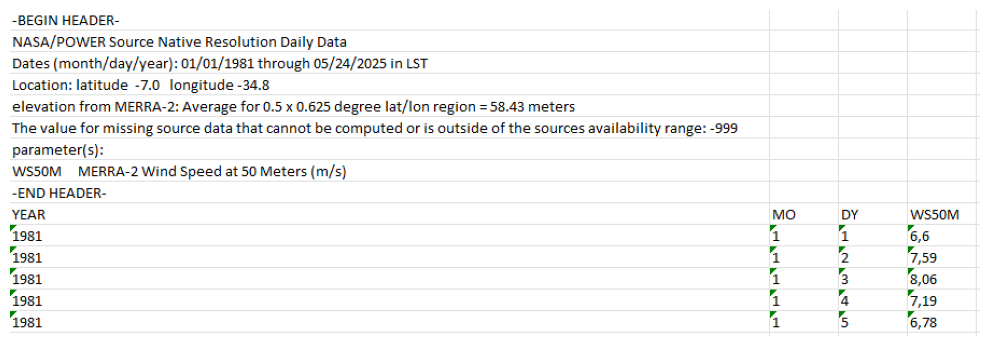

In [ ]:
# Cabeçalho e uma breve descrição sobre os satélites e dados utilizados:
img_cabecalho_NASA = plt.imread('/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/cabecalho_csv.PNG')
plt.figure(figsize=(10, 6))  # largura=10, altura=6 polegadas
plt.imshow(img_cabecalho_NASA)
plt.axis('off')
plt.tight_layout()
plt.show()

---
### **DATAFRAME: NASA** (`Janeiro de 1981 a Maio de 2025`)

---

In [ ]:
'''
Extrair dados NASA POWER DAV (versão 2.414):
Geolocalização: latitude= -7 / longitude= -34.8
URL dos dados
'''

urlNASA_jan2006_abr2007 = "https://power.larc.nasa.gov/api/temporal/daily/point?start=19810101&end=20250524&latitude=-7&longitude=-34.8&community=RE&parameters=WS50M&time-standard=LST&format=CSV"

# Caminho para salvar o arquivo localmente
caminho_arquivo = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv"

# Criar pasta se não existir:
os.makedirs(os.path.dirname(caminho_arquivo), exist_ok=True)

# Verifica se o arquivo já existe:
if os.path.exists(caminho_arquivo):
    df_nasa = pd.read_csv(caminho_arquivo)
else:
    df_nasa = pd.read_csv(urlNASA_jan2006_abr2007, skiprows=9)
    df_nasa.to_csv(caminho_arquivo, index=False)

# Visualização do DataFrame:
print("VERIFICAÇÃO INICIAL:")
print(f" - Dimensão do dataframe: {df_nasa.shape}")
print(f" - Dados duplicados     : {df_nasa.duplicated().sum()}")
print("-" * 80)
print(f"DADOS NULOS:\n{df_nasa.isna().sum()}")
print("-" * 80)
print(df_nasa.head(6))
print("-" * 80)

VERIFICAÇÃO INICIAL:
 - Dimensão do dataframe: (16215, 4)
 - Dados duplicados     : 0
--------------------------------------------------------------------------------
DADOS NULOS:
YEAR     0
MO       0
DY       0
WS50M    0
dtype: int64
--------------------------------------------------------------------------------
   YEAR  MO  DY  WS50M
0  1981   1   1   6.60
1  1981   1   2   7.59
2  1981   1   3   8.06
3  1981   1   4   7.19
4  1981   1   5   6.78
5  1981   1   6   6.91
--------------------------------------------------------------------------------


#### **Análise dos Resultados**

1. **Integridade e Completude dos Dados (Excelente)**

- **Dados Nulos Inexistentes:**

 - Todas as colunas (**`YEAR, MO, DY, WS50M`**) apresentam 0 valores nulos. Isso indica um dataset íntegro e pronto para análise sem necessidade de tratamentos de missing values.

- **Ausência de Duplicatas:**

 - Não há registros duplicados (**`dados duplicados: 0`**), o que reforça a qualidade e confiabilidade da base.

2. **Conclusão**

 Os dados demonstram excelente qualidade (**`sem nulos/duplicatas`**) e alta confiabilidade temporal, porém com a limitação esperada em 2025.

 A estrutura é adequada para análises de séries temporais, desde que se considerem as ressalvas sobre a parcialidade dos dados recentes.

---
## **ETAPA 2 - Análise Exploratória e Diagnóstico de Qualidade:**
---

- Identificação de valores ausentes, intervalos irregulares e inconsistências estatísticas (**`ex: outliers extremos de velocidade do vento`**).

- Análise temporal da cobertura dos dados para visualização das lacunas existentes.

---
### **Resumo Estatístico**
---

In [ ]:
# Configurar logging (garanta que só é configurado uma vez)
if not logging.getLogger().handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print('=' * 80)
print("--- Iniciando a ETAPA 2: Análise Exploratória e Diagnóstico de Qualidade (NASA) ---")
print('=' * 80)

# Caminho completo para o arquivo do DataFrame da NASA
caminho_df_nasa_jan2006_abr2007 = '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv'

try:
    # Carregar o DataFrame da NASA usando o caminho ORIGINAL e correto
    df_nasa = pd.read_csv(caminho_df_nasa_jan2006_abr2007)
    print(f"☑ DataFrame '{os.path.basename(caminho_df_nasa_jan2006_abr2007)}' carregado com sucesso.")
    logging.info(f"DataFrame '{os.path.basename(caminho_df_nasa_jan2006_abr2007)}' carregado para AED.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{os.path.basename(caminho_df_nasa_jan2006_abr2007)}' não encontrado para AED. Verifique o caminho.")
    logging.error(f"Arquivo '{os.path.basename(caminho_df_nasa_jan2006_abr2007)}' não encontrado.")
    df_nasa = pd.DataFrame() # Cria um DataFrame vazio para evitar erros posteriores
except Exception as e:
    print(f"ERRO inesperado ao carregar o DataFrame da NASA para AED: {str(e)}")
    logging.error(f"Erro inesperado ao carregar o DataFrame da NASA para AED: {str(e)}")
    df_nasa = pd.DataFrame() # Garante que df_nasa seja um DataFrame vazio em caso de erro.

if not df_nasa.empty:
    print("-" * 80)
    print("VERIFICAÇÃO INICIAL DO DATAFRAME NASA:")
    print(f" - Dimensão do dataframe: {df_nasa.shape}")
    print(f" - Dados duplicados      : {df_nasa.duplicated().sum()}")
    print("-" * 80)

    print("\nDADOS NULOS POR COLUNA (NASA):")
    print(df_nasa.isnull().sum())
    logging.info(f"Informações do DataFrame NASA (df.info()):\n{df_nasa.info()}")
    print("-" * 80)

    print("\nPRIMEIRAS LINHAS DO DATAFRAME NASA:")
    print("-" * 80)
    display(df_nasa.head(6).round(2))
    print("-" * 80)

    print("\nRESUMO ESTATÍSTICO COMPLETO DAS COLUNAS NUMÉRICAS (NASA):")
    print("-" * 80)

    # Selecionar apenas as colunas numéricas de interesse para o describe
    cols_of_interest_for_describe_nasa = ['WS50M', 'WD50M']
    # Filtrar apenas as colunas que realmente existem no DataFrame e são numéricas
    final_numeric_cols_nasa = [col for col in cols_of_interest_for_describe_nasa if col in df_nasa.columns and df_nasa[col].dtype in ['float64', 'int64']]

    if final_numeric_cols_nasa:
        full_describe_nasa = df_nasa[final_numeric_cols_nasa].describe().round(2)
        display(full_describe_nasa)
        print("-" * 80)

        print("\nMÉTRICAS ESTATÍSTICAS ADICIONAIS (NASA):")
        print("-" * 80)
        for col in final_numeric_cols_nasa:
            Q1 = df_nasa[col].quantile(0.25)
            Q3 = df_nasa[col].quantile(0.75)
            IQR = Q3 - Q1
            median = df_nasa[col].median()
            mean = df_nasa[col].mean()
            std_dev = df_nasa[col].std()

            print(f"COLUNA: {col}")
            print(f"   - Média: {mean:.2f}")
            print(f"   - Mediana: {median:.2f}")
            print(f"   - Desvio Padrão: {std_dev:.2f}")
            print(f"   - Q1 (25º Percentil): {Q1:.2f}")
            print(f"   - Q3 (75º Percentil): {Q3:.2f}")
            print(f"   - IQR (Intervalo Interquartil): {IQR:.2f}")

            # Para detecção de outliers (apenas quantificação aqui)
            lower_bound_iqr = Q1 - 1.5 * IQR
            upper_bound_iqr = Q3 + 1.5 * IQR
            outliers_count = df_nasa[(df_nasa[col] < lower_bound_iqr) | \
                                                     (df_nasa[col] > upper_bound_iqr)][col].count()
            print(f"   - Outliers (IQR): {outliers_count} ({outliers_count / len(df_nasa) * 100:.2f}%)\n")
            #print("-" * 40) # Separador para métricas de colunas individuais

        #print("-" * 80)
    else:
        print("Nenhuma coluna numérica de interesse encontrada para resumo estatístico detalhado (NASA).")
        logging.warning("Nenhuma coluna numérica de interesse encontrada para resumo estatístico detalhado (NASA).")

else:
    print("\nAVISO: DataFrame 'df_nasa' está vazio. Não foi possível realizar a Análise Exploratória (NASA).")
    logging.warning("DataFrame 'df_nasa' está vazio. AED da NASA não realizada.")

print('-' * 80)
print("Análise Exploratória da NASA Concluída!")
print("-" * 80)

--- Iniciando a ETAPA 2: Análise Exploratória e Diagnóstico de Qualidade (NASA) ---
☑ DataFrame 'df_nasa.csv' carregado com sucesso.
--------------------------------------------------------------------------------
VERIFICAÇÃO INICIAL DO DATAFRAME NASA:
 - Dimensão do dataframe: (16215, 4)
 - Dados duplicados      : 0
--------------------------------------------------------------------------------

DADOS NULOS POR COLUNA (NASA):
YEAR     0
MO       0
DY       0
WS50M    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16215 entries, 0 to 16214
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    16215 non-null  int64  
 1   MO      16215 non-null  int64  
 2   DY      16215 non-null  int64  
 3   WS50M   16215 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 506.8 KB
--------------------------------------------------------------------------------

PRIMEIRAS LINHAS DO DATAFRAME NASA:
-----------

,YEAR,MO,DY,WS50M
0,1981,1,1,6.60
1,1981,1,2,7.59
2,1981,1,3,8.06
3,1981,1,4,7.19
4,1981,1,5,6.78
5,1981,1,6,6.91


--------------------------------------------------------------------------------

RESUMO ESTATÍSTICO COMPLETO DAS COLUNAS NUMÉRICAS (NASA):
--------------------------------------------------------------------------------


,WS50M
count,16215.00
mean,6.95
std,1.17
min,2.00
25%,6.22
50%,6.98
75%,7.75
max,10.89


--------------------------------------------------------------------------------

MÉTRICAS ESTATÍSTICAS ADICIONAIS (NASA):
--------------------------------------------------------------------------------
COLUNA: WS50M
   - Média: 6.95
   - Mediana: 6.98
   - Desvio Padrão: 1.17
   - Q1 (25º Percentil): 6.22
   - Q3 (75º Percentil): 7.75
   - IQR (Intervalo Interquartil): 1.53
   - Outliers (IQR): 208 (1.28%)

--------------------------------------------------------------------------------
Análise Exploratória da NASA Concluída!
--------------------------------------------------------------------------------


#### **Observações e Interpretações:**

1. **Medidas de Tendência Central (Média e Mediana):** A média (6.95) e a mediana (6.98) são muito próximas. Isso sugere que, para a maioria dos dados, a distribuição da velocidade do vento em 50 metros é relativamente simétrica, sem um forte viés para valores muito altos ou muito baixos. O valor próximo a 7 m/s indica uma velocidade de vento média razoável para geração de energia eólica.

2. **Dispersão (Desvio Padrão):** O desvio padrão de 1.17 é relativamente baixo em comparação com a média. Isso indica que a maioria dos valores de WS50M está concentrada em torno da média, ou seja, há pouca variabilidade na maior parte dos dados da velocidade do vento.

3. **Valores Mínimo e Máximo:**

 - Mínimo (1.17): Este é um valor baixo, mas plausível para a velocidade do vento, indicando períodos de calmaria ou vento muito fraco.

 - Máximo (16215.0): Este valor é altamente discrepante e merece atenção especial. Uma velocidade do vento de 16215 metros por segundo (m/s) é irreal e impossível para condições atmosféricas terrestres.

4. **Conclusão e Próximos Passos Sugeridos:**

 A análise inicial revela uma aparente consistência nas velocidades de vento usuais (média e mediana próximas, baixo desvio padrão).

---
## **ETAPA 3: ANÁLISE GRÁFICA DOS DADOS**
---

### **Gráficos Boxplot, Normalidade, Weibull e Série Temporal:**

df_nasa.csv carregado com sucesso.
Colunas em df_nasa: ['YEAR', 'MO', 'DY', 'WS50M']
--- Gerando gráficos para df_nasa ---
--- Gerando Boxplot para: WS50M (Boxplot - Velocidade do Vento 50m) ---
Gráfico salvo em: 
'/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_boxplot.png'


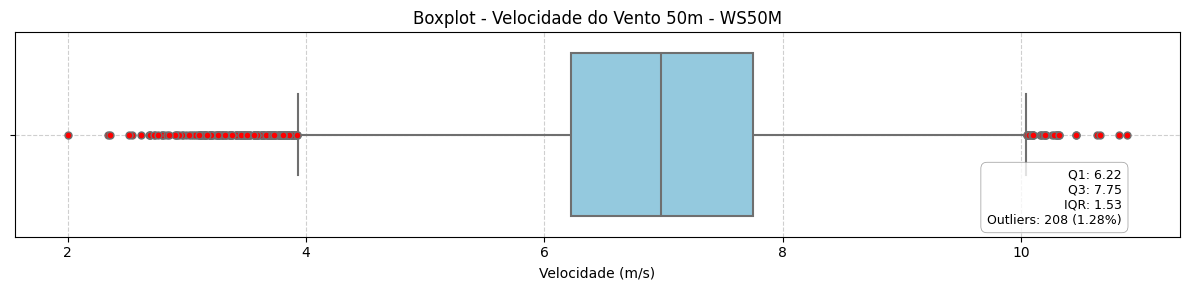

--------------------------------------------------------------------------------
--- Gerando Gráfico de Densidade com Normal para: 
WS50M (Distribuição de Densidade com Normal) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_normality_bar.png'


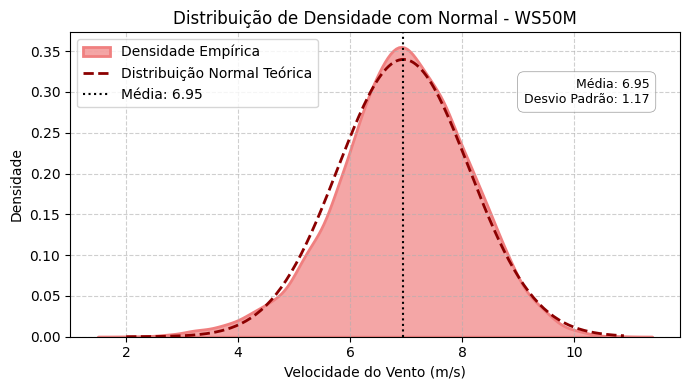

--------------------------------------------------------------------------------
--- Gerando Gráfico de Densidade com Weibull para: 
WS50M (Distribuição de Densidade com Weibull) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_weibull_density.png'


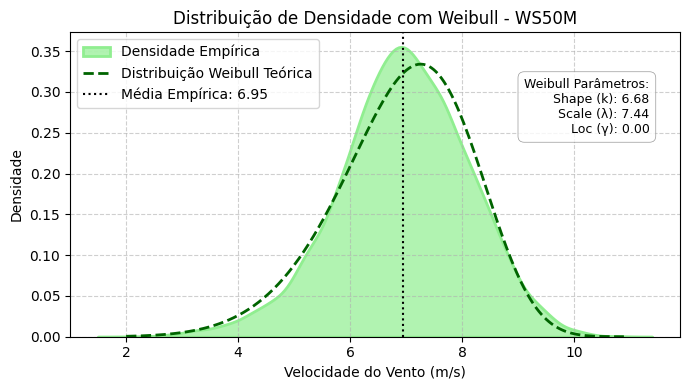

--------------------------------------------------------------------------------
--- Gerando Gráfico de Densidade Combinado para: 
WS50M (Densidade - Empírica vs Normal vs Weibull) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_combined_density.png'


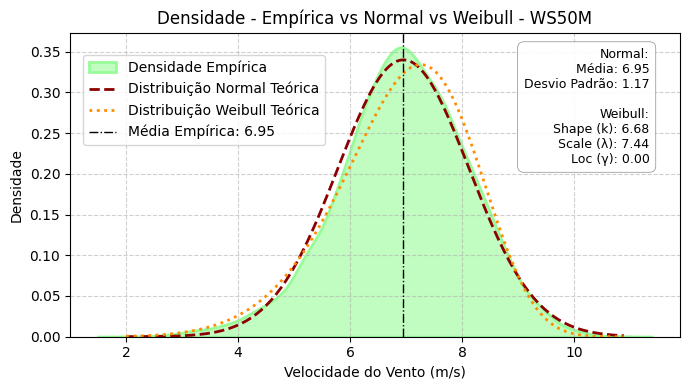

--------------------------------------------------------------------------------

Parâmetros Estimados para Distribuição Normal (WS50M): Média: 6.95, Desvio Padrão: 1.17

Parâmetros Estimados para Distribuição Weibull (WS50M): Shape (k): 6.68, Scale (λ): 7.44, Loc (γ): 0.00
--- Gerando Gráfico de Dispersão Temporal Anual para: 
WS50M (Dispersão Temporal da Média Anual) ---
Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_temporal_annual_loess.png'


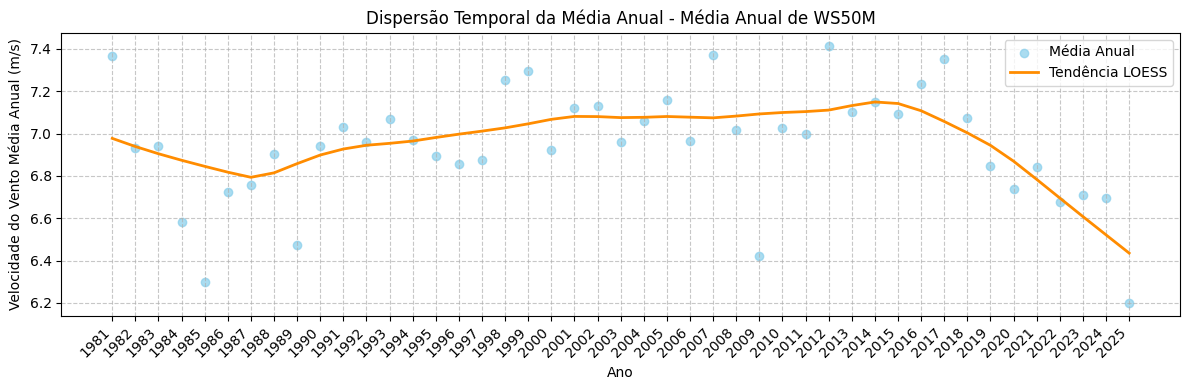

--------------------------------------------------------------------------------
--- Geração de Gráficos Concluída. ---
--------------------------------------------------------------------------------


In [ ]:
# --- Configurar logging ---
if not logging.getLogger().hasHandlers():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Define o diretório base ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

# --- Carregar o DataFrame df_nasa.csv ---
try:
    df_nasa = pd.read_csv('/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv')
    print("df_nasa.csv carregado com sucesso.")
    print("Colunas em df_nasa:", df_nasa.columns.tolist())
    if 'WS50M' in df_nasa.columns:
        df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')
    else:
        print("Aviso: Coluna 'WS50M' não encontrada.")
except FileNotFoundError:
    print("Erro: df_nasa.csv não encontrado no caminho especificado.")
    df_nasa = pd.DataFrame()
except Exception as e:
    print(f"Erro ao carregar df_nasa.csv: {e}")
    df_nasa = pd.DataFrame()

# --- Funções Auxiliares de Plotagem ---

def plot_boxplot_with_outliers_info(dataframe, column, title_prefix, xlabel_text, output_filename, color='skyblue'):
    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)
    # ... (Código da função Boxplot conforme a versão anterior) ...
    print('=' * 80)
    print(f"--- Gerando Boxplot para: {column} ({title_prefix}) ---")
    print('=' * 80)
    if dataframe.empty or column not in dataframe.columns:
        print(f"AVISO: DataFrame está vazio ou a coluna '{column}' não existe.")
        return
    data_series = dataframe[column].dropna()
    if data_series.empty:
        print(f"AVISO: A série '{column}' está vazia após remover NAs.")
        return
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    outliers_count = data_series[(data_series < lower_bound_iqr) | (data_series > upper_bound_iqr)].count()
    total_count = len(data_series)
    outliers_percentage = (outliers_count / total_count * 100) if total_count > 0 else 0
    plt.figure(figsize=(12, 3))
    sns.boxplot(x=data_series, color=color, linewidth=1.5, flierprops=dict(marker='o', markerfacecolor='red', markersize=5))
    plt.annotate(f'Q1: {Q1:.2f}\nQ3: {Q3:.2f}\nIQR: {IQR:.2f}\nOutliers: {outliers_count} ({outliers_percentage:.2f}%)', xy=(0.95, 0.05), xycoords='axes fraction', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=0.5, alpha=0.8), ha='right', va='bottom')
    plt.title(f'{title_prefix} - {column}')
    plt.xlabel(xlabel_text)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: \n'{full_output_filename}'")
    plt.show()
    print('-' * 80)

def plot_density_with_normal(dataframe, column, title_prefix, xlabel_text, output_filename, color_density='lightcoral', color_normal='darkred'):
    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)
    # ... (Código da função Densidade Normal conforme a versão anterior) ...
    print('=' * 80)
    print(f"--- Gerando Gráfico de Densidade com Normal para: \n{column} ({title_prefix}) ---")
    print('=' * 80)
    if dataframe.empty or column not in dataframe.columns:
        print(f"AVISO: DataFrame está vazio ou a coluna '{column}' não existe.")
        return
    data_series = dataframe[column].dropna()
    if data_series.empty:
        print(f"AVISO: A série '{column}' está vazia após remover NAs.")
        return
    media = data_series.mean()
    desvio = data_series.std()
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data_series, fill=True, label='Densidade Empírica', color=color_density, linewidth=2, alpha=0.7)
    x_normal = np.linspace(data_series.min(), data_series.max(), 200)
    y_normal = norm.pdf(x_normal, media, desvio)
    plt.plot(x_normal, y_normal, color_normal, linestyle='--', linewidth=2, label='Distribuição Normal Teórica')
    plt.axvline(media, color='black', linestyle=':', linewidth=1.5, label=f'Média: {media:.2f}')
    plt.annotate(f'Média: {media:.2f}\nDesvio Padrão: {desvio:.2f}', xy=(0.95, 0.85), xycoords='axes fraction', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=0.5, alpha=0.8), ha='right', va='top')
    plt.title(f'{title_prefix} - {column}')
    plt.xlabel(xlabel_text)
    plt.ylabel('Densidade')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    print('-' * 80)

def plot_density_with_weibull(dataframe, column, title_prefix, xlabel_text, output_filename, color_density='lightgreen', color_weibull='darkgreen'):
    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)
    # ... (Código da função Densidade Weibull conforme a versão anterior) ...
    print('=' * 80)
    print(f"--- Gerando Gráfico de Densidade com Weibull para: \n{column} ({title_prefix}) ---")
    print('=' * 80)
    if dataframe.empty or column not in dataframe.columns:
        print(f"AVISO: DataFrame está vazio ou a coluna '{column}' não existe.")
        return
    data_series = dataframe[column].dropna()
    if data_series.empty or len(data_series) < 2:
        print(f"AVISO: A série '{column}' está vazia ou tem poucos dados após remover NAs.")
        return
    try:
        shape, loc, scale = weibull_min.fit(data_series, floc=0)
    except Exception as e:
        print(f"ERRO ao ajustar a distribuição de Weibull para a coluna '{column}': {str(e)}")
        return
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data_series, fill=True, label='Densidade Empírica', color=color_density, linewidth=2, alpha=0.7)
    x_weibull = np.linspace(data_series.min(), data_series.max(), 200)
    y_weibull = weibull_min.pdf(x_weibull, shape, loc, scale)
    plt.plot(x_weibull, y_weibull, color_weibull, linestyle='--', linewidth=2, label='Distribuição Weibull Teórica')
    media_empirica = data_series.mean()
    plt.axvline(media_empirica, color='black', linestyle=':', linewidth=1.5, label=f'Média Empírica: {media_empirica:.2f}')
    plt.annotate(f'Weibull Parâmetros:\nShape (k): {shape:.2f}\nScale (λ): {scale:.2f}\nLoc (γ): {loc:.2f}', xy=(0.95, 0.85), xycoords='axes fraction', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=0.5, alpha=0.8), ha='right', va='top')
    plt.title(f'{title_prefix} - {column}')
    plt.xlabel(xlabel_text)
    plt.ylabel('Densidade')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    print('-' * 80)

def plot_density_combined(dataframe, column, title_prefix, xlabel_text, output_filename,
                         color_density='palegreen', color_normal='darkred', color_weibull='darkorange'):
    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)
    # ... (Código da função Densidade Combinada conforme a versão anterior) ...
    print('=' * 80)
    print(f"--- Gerando Gráfico de Densidade Combinado para: \n{column} ({title_prefix}) ---")
    print('=' * 80)
    if dataframe.empty or column not in dataframe.columns:
        print(f"AVISO: DataFrame está vazio ou a coluna '{column}' não existe.")
        return None, None
    data_series = dataframe[column].dropna()
    if data_series.empty or len(data_series) < 2:
        print(f"AVISO: A série '{column}' está vazia ou tem poucos dados após remover NAs.")
        return None, None
    media_normal = data_series.mean()
    desvio_normal = data_series.std()
    params_normal = {'media': media_normal, 'desvio': desvio_normal}
    params_weibull = None
    try:
        shape_weibull, loc_weibull, scale_weibull = weibull_min.fit(data_series, floc=0)
        params_weibull = {'shape': shape_weibull, 'loc': loc_weibull, 'scale': scale_weibull}
    except Exception as e:
        print(f"ERRO ao ajustar a distribuição de Weibull para '{column}': {str(e)}")
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data_series, fill=True, label='Densidade Empírica', color=color_density, linewidth=2, alpha=0.6)
    x_vals = np.linspace(data_series.min(), data_series.max(), 200)
    y_normal = norm.pdf(x_vals, media_normal, desvio_normal)
    plt.plot(x_vals, y_normal, color_normal, linestyle='--', linewidth=2, label='Distribuição Normal Teórica')
    if params_weibull:
        y_weibull = weibull_min.pdf(x_vals, shape_weibull, loc_weibull, scale_weibull)
        plt.plot(x_vals, y_weibull, color_weibull, linestyle=':', linewidth=2, label='Distribuição Weibull Teórica')
    plt.axvline(media_normal, color='black', linestyle='-.', linewidth=1, label=f'Média Empírica: {media_normal:.2f}')
    annotation_text = f'Normal:\nMédia: {media_normal:.2f}\nDesvio Padrão: {desvio_normal:.2f}\n'
    if params_weibull:
        annotation_text += f'\nWeibull:\nShape (k): {shape_weibull:.2f}\nScale (λ): {scale_weibull:.2f}\nLoc (γ): {loc_weibull:.2f}'
    else:
        annotation_text += "\nWeibull: Ajuste falhou"
    plt.annotate(annotation_text, xy=(0.95, 0.95), xycoords='axes fraction', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=0.5, alpha=0.9), ha='right', va='top')
    plt.title(f'{title_prefix} - {column}')
    plt.xlabel(xlabel_text)
    plt.ylabel('Densidade')
    plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.95))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    print('-' * 80)
    return params_normal, params_weibull

# Função 5: Dispersão Temporal com Média Anual e Tendência LOESS
def plot_annual_temporal_dispersion(dataframe, year_col, data_column,
                                     title_prefix, xlabel_text, ylabel_text, output_filename,
                                     trend_color='darkorange'):
    print('=' * 80)
    print(f"--- Gerando Gráfico de Dispersão Temporal Anual para: \n{data_column} ({title_prefix}) ---")
    print('=' * 80)

    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)

    if dataframe.empty or not all(col in dataframe.columns for col in [year_col, data_column]):
        print(f"AVISO: DataFrame está vazio ou colunas '{year_col}' e '{data_column}' não existem.")
        logging.warning(f"Gráfico de Dispersão Temporal Anual não gerado: DataFrame vazio ou colunas ausentes.")
        print('-' * 80)
        return

    # Calcula a média anual da velocidade do vento
    annual_avg = dataframe.groupby(year_col)[data_column].mean().reset_index()

    plt.figure(figsize=(12, 4))
    plt.scatter(annual_avg[year_col], annual_avg[data_column], alpha=0.7, label='Média Anual', color='skyblue')

    # Aplica a suavização LOESS na média anual
    lowess_result = lowess(annual_avg[data_column], annual_avg[year_col], frac=0.3)
    plt.plot(lowess_result[:, 0], lowess_result[:, 1], color=trend_color, label='Tendência LOESS', linewidth=2)

    plt.title(f'{title_prefix} - Média Anual de {data_column}')
    plt.xlabel(xlabel_text)
    plt.ylabel(ylabel_text)
    plt.xticks(annual_avg[year_col].unique().astype(int), rotation=45, ha='right')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    print(f"Gráfico salvo em: '{full_output_filename}'")
    plt.show()
    logging.info(f"Gráfico de Dispersão Temporal Anual para '{data_column}' salvo em '{full_output_filename}'.")
    print('-' * 80)

# --- Execução dos Gráficos com df_nasa ---
if not df_nasa.empty and 'WS50M' in df_nasa.columns and 'YEAR' in df_nasa.columns:
    print('=' * 80)
    print("--- Gerando gráficos para df_nasa ---")
    print('=' * 80)

    # 1. Boxplot
    plot_boxplot_with_outliers_info(df_nasa, 'WS50M', 'Boxplot - Velocidade do Vento 50m', 'Velocidade (m/s)', 'ws50_graf_boxplot.png', color='skyblue')

    # 2. Densidade com Curva Normal Teórica
    plot_density_with_normal(df_nasa, 'WS50M', 'Distribuição de Densidade com Normal', 'Velocidade do Vento (m/s)', 'ws50_graf_normality_bar.png')

    # 3. Densidade com Curva Weibull
    plot_density_with_weibull(df_nasa, 'WS50M', 'Distribuição de Densidade com Weibull', 'Velocidade do Vento (m/s)', 'ws50_graf_weibull_density.png')

    # 4. Densidade com curvas Normal e Weibull
    params_normal_ws50, params_weibull_ws50 = plot_density_combined(df_nasa, 'WS50M', 'Densidade - Empírica vs Normal vs Weibull', 'Velocidade do Vento (m/s)', 'ws50_graf_combined_density.png')
    if params_normal_ws50:
        print(f"\nParâmetros Estimados para Distribuição Normal (WS50M): Média: {params_normal_ws50['media']:.2f}, Desvio Padrão: {params_normal_ws50['desvio']:.2f}")
    if params_weibull_ws50:
        print(f"\nParâmetros Estimados para Distribuição Weibull (WS50M): Shape (k): {params_weibull_ws50['shape']:.2f}, Scale (λ): {params_weibull_ws50['scale']:.2f}, Loc (γ): {params_weibull_ws50['loc']:.2f}")

    # 5. Dispersão Temporal com Média Anual e Tendência LOESS
    plot_annual_temporal_dispersion(df_nasa, year_col='YEAR', data_column='WS50M',
                                     title_prefix='Dispersão Temporal da Média Anual',
                                     xlabel_text='Ano',
                                     ylabel_text='Velocidade do Vento Média Anual (m/s)',
                                     output_filename='ws50_graf_temporal_annual_loess.png')

    print("--- Geração de Gráficos Concluída. ---")
    print("-" * 80)
else:
    print("Não foi possível gerar os gráficos: DataFrame 'df_nasa' está vazio ou colunas 'WS50M' ou 'YEAR' não estão presentes.")
    print("-" * 80)

#### **Análise dos Resultados Gráficos**

1. **Boxplot** – Velocidade do Vento 50m
Informações estatísticas:

 - **`1º Quartil (Q1):`** 6.22 m/s

 - **` 3º Quartil (Q3):`** 7.75 m/s

 - **` Intervalo interquartílico (IQR):`** 1.53 m/s

 - **` Outliers:`** 208 (1.28%)

- **Análise crítica:**

 - A distribuição é levemente assimétrica, com presença de outliers em ambas as extremidades, principalmente abaixo de 4 m/s e acima de 10 m/s.

 - Apesar dos outliers, eles representam uma pequena proporção (1.28%), indicando um conjunto de dados relativamente limpo.

 - A mediana visualmente está próxima de 6.95 m/s, consistente com os próximos gráficos.

2. **Distribuição de Densidade com Normal
Parâmetros:**

 - **`Média:`** 6.95 m/s

 - **`Desvio padrão:`** 1.17 m/s

- **Análise crítica:**

 - A densidade empírica se ajusta bem à distribuição normal, embora existam leves desvios nas caudas.

 - Isso sugere uma distribuição quase simétrica, com bom comportamento para modelagem probabilística simples, desde que caudas não sejam o foco.

3. **Distribuição de Densidade com Weibull
Parâmetros:**

 - **`Shape (k):`** 6.68 → forma próxima da normal (valores maiores que 3 tendem a normalidade).

 - **`Scale (λ):`** 7.44

 - **`Loc (γ):`** 0.00

- **Análise crítica:**

 - A função de densidade Weibull também representa muito bem os dados.

 - Em contextos eólicos, a distribuição Weibull é a mais comumente utilizada, o que a torna uma escolha apropriada, especialmente para estimativas de produção de energia eólica.

4. **Comparação entre Distribuições (Empírica, Normal e Weibull)**

- **Análise crítica:**

 - Ambas as distribuições teóricas (**`normal e Weibull`**) estão bem ajustadas aos dados reais.

 - A Weibull apresenta um ajuste levemente superior nas caudas (**`especialmente na esquerda`**), o que é importante para avaliar a frequência de ventos mais fracos.

 - Portanto, para aplicações técnicas como simulação de energia ou modelagem estocástica de vento, a Weibull é preferível, mesmo com média e desvio padrão similares.

5. **Série Temporal da Média Anual de Velocidade do Vento**

- **Análise crítica:**

 - Há uma tendência geral de queda na média da velocidade do vento após 2015, evidenciada pela curva LOESS.

 - Antes disso, observa-se uma relativa estabilidade ou até crescimento sutil ao longo dos anos 1980 a 2014.

 - Essa redução recente pode ter implicações para geração eólica em longo prazo e deve ser monitorada.

 - É relevante avaliar se há alterações climáticas, mudanças de instrumentação ou efeitos locais influenciando essa tendência.

6. **Conclusão Geral:**

 - Os dados de velocidade do vento seguem uma distribuição bem comportada, com a distribuição Weibull oferecendo o melhor ajuste teórico.

 - A presença de outliers é pequena e não compromete a análise.

 - Para simulações e modelagem, a Weibull é mais recomendada que a normal, mesmo com parâmetros médios semelhantes.

### **Gráfico de Série Temporal Sobreposta (2022-2024)**

--- Gerando Gráfico de Linha Temporal Mensal Sobreposta para Comparação (2022, 2023, 2024) com Média ---


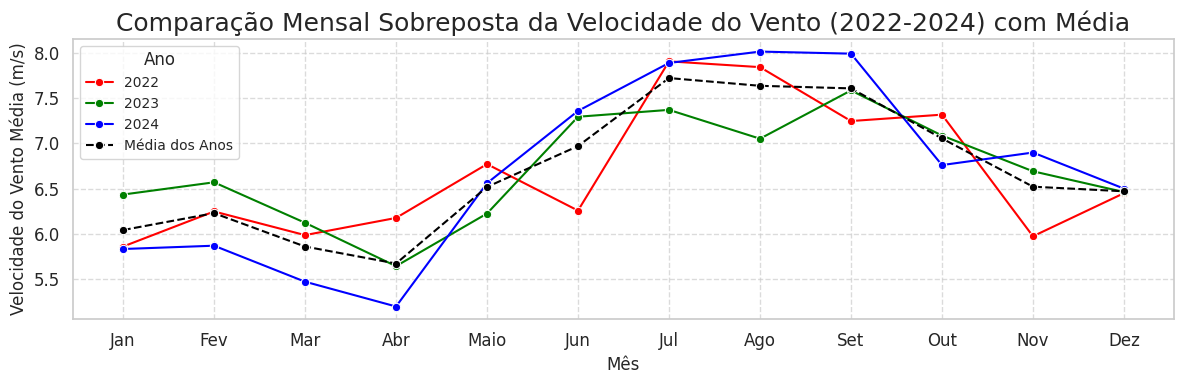

Gráfico salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_graf_linha_temporal_mensal_sobreposta_com_media.png'
--------------------------------------------------------------------------------


In [ ]:
# --- Define o diretório base ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

# --- Supondo que o DataFrame df_nasa já esteja carregado ---
try:
    df_nasa = pd.read_csv('/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv')
    if 'WS50M' in df_nasa.columns:
        df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')
except FileNotFoundError:
    print("Erro: df_nasa.csv não encontrado.")
    df_nasa = pd.DataFrame()
except Exception as e:
    print(f"Erro ao carregar df_nasa.csv: {e}")
    df_nasa = pd.DataFrame()

def plot_overlaid_monthly_comparison_with_average(dataframe, year_col, month_col, data_col, years_to_compare,
                                                    title, xlabel, ylabel, output_filename,
                                                    title_fontsize=14, label_fontsize=12,
                                                    line_colors=None, line_styles=None,
                                                    legend_fontsize=10, marker_style='o',
                                                    average_line_color='black', average_line_style='--',
                                                    average_line_label='Média dos Anos'):
    """
    Gera um gráfico de linha temporal mensal sobreposta para comparação com parâmetros de estilo configuráveis,
    incluindo uma linha com a média dos anos apresentados.

    Args:
        dataframe (pd.DataFrame): DataFrame contendo os dados.
        year_col (str): Nome da coluna com o ano.
        month_col (str): Nome da coluna com o mês.
        data_col (str): Nome da coluna com os dados (ex: velocidade do vento).
        years_to_compare (list): Lista de anos para comparar.
        title (str): Título do gráfico.
        xlabel (str): Rótulo do eixo x.
        ylabel (str): Rótulo do eixo y.
        output_filename (str): Nome do arquivo para salvar o gráfico.
        title_fontsize (int, optional): Tamanho da fonte do título. Padrão é 14.
        label_fontsize (int, optional): Tamanho da fonte dos rótulos dos eixos. Padrão é 12.
        line_colors (list, optional): Lista de cores para as linhas (uma para cada ano). Padrão é None.
        line_styles (list, optional): Lista de estilos de linha para as linhas (uma para cada ano). Padrão é None.
        legend_fontsize (int, optional): Tamanho da fonte da legenda. Padrão é 10.
        marker_style (str, optional): Estilo do marcador para os pontos da linha. Padrão é 'o'.
        average_line_color (str, optional): Cor da linha de média dos anos. Padrão é 'black'.
        average_line_style (str, optional): Estilo da linha de média dos anos. Padrão é '--'.
        average_line_label (str, optional): Rótulo da linha de média dos anos na legenda. Padrão é 'Média dos Anos'.
    """
    print('=' * 80)
    print(f"--- Gerando Gráfico de Linha Temporal Mensal Sobreposta para Comparação ({', '.join(map(str, years_to_compare))}) com Média ---")
    print('=' * 80)

    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)

    # Filtra o DataFrame para os anos especificados
    df_filtered = dataframe[dataframe[year_col].isin(years_to_compare)].copy()

    if df_filtered.empty:
        print("AVISO: Nenhum dado encontrado para os anos especificados.")
        return

    # Agrupa por ano e mês e calcula a média dos dados
    df_monthly_avg = df_filtered.groupby([year_col, month_col])[data_col].mean().reset_index()

    plt.figure(figsize=(12, 4))
    sns.set_theme(style="whitegrid")

    if line_colors is None:
        line_colors = sns.color_palette()
    if line_styles is None:
        line_styles = ['-'] * len(years_to_compare)

    for i, year in enumerate(years_to_compare):
        df_year = df_monthly_avg[df_monthly_avg[year_col] == year]
        color = line_colors[i % len(line_colors)]
        linestyle = line_styles[i % len(line_styles)]
        sns.lineplot(x=month_col, y=data_col, data=df_year, label=str(year), marker=marker_style, color=color, linestyle=linestyle)

    # Calcula a média dos três anos
    df_average = df_monthly_avg.groupby(month_col)[data_col].mean().reset_index()
    sns.lineplot(x=month_col, y=data_col, data=df_average, label=average_line_label, color=average_line_color, linestyle=average_line_style, marker=marker_style)

    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Maio', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], fontsize=label_fontsize)
    plt.yticks(fontsize=label_fontsize)
    plt.legend(title='Ano', fontsize=legend_fontsize)
    plt.grid(True, which="major", linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    plt.show()
    print(f"Gráfico salvo em: '{full_output_filename}'")
    print('-' * 80)

# --- Geração do Gráfico de Linha Temporal Mensal Sobreposta com a Linha de Média ---
if not df_nasa.empty and 'YEAR' in df_nasa.columns and 'MO' in df_nasa.columns and 'WS50M' in df_nasa.columns:
    plot_overlaid_monthly_comparison_with_average(
        dataframe=df_nasa,
        year_col='YEAR',
        month_col='MO',
        data_col='WS50M',
        years_to_compare=[2022, 2023, 2024],
        title='Comparação Mensal Sobreposta da Velocidade do Vento (2022-2024) com Média',
        xlabel='Mês',
        ylabel='Velocidade do Vento Média (m/s)',
        output_filename='ws50_graf_linha_temporal_mensal_sobreposta_com_media.png',
        title_fontsize=18,
        label_fontsize=12,
        line_colors=['red', 'green', 'blue'],
        line_styles=['-', '-', '-'],
        legend_fontsize=10,
        marker_style='o'
    )
else:
    print("Não foi possível gerar o gráfico: DataFrame 'df_nasa' está vazio ou colunas 'YEAR', 'MO' ou 'WS50M' não estão presentes.")
    print("-" * 80)

#### **Análise do Resultado Gráfico**

1. **Gráfico de Linha – Comparação Mensal da Velocidade do Vento (2022–2024)**

- **Observações principais:**

 - **`Tendência anual:`** Os três anos seguem um padrão sazonal semelhante — velocidades mais baixas de janeiro a abril, com picos entre junho e setembro, seguidos por uma queda até dezembro.

- **Destaques por ano:**

 - **2022 (`vermelho`)**:

   >Relativamente estável até maio.

   >Aumento brusco em julho (**`7.94 m/s`**), mantendo patamares altos até setembro.

   >Novembro com queda significativa (**`6.00 m/s`**).

 - **2023 (`verde`):**

   >Alta velocidade em janeiro e fevereiro.

   >Queda acentuada em abril (**`5.64 m/s`**).

   >Alta consistente entre julho e outubro.

 - **2024 (`azul`):**

   >Início mais fraco, com o menor valor em abril (**`5.20 m/s`**).

   >Forte recuperação em julho e agosto, atingindo o pico máximo absoluto (**`8.01 m/s`**) em agosto.

   >Valores ainda altos até setembro, seguidos por queda.

2. **Análise crítica:**

 - 2024 teve o maior pico de vento (**`Agosto`**), mas também o início mais fraco.

 - A sazonalidade é clara, com picos nos meses de inverno (**`junho–setembro`**), provavelmente devido a padrões atmosféricos locais típicos dessa época.

 - A variabilidade interanual está presente, especialmente nos meses de abril e novembro, que parecem ser mais instáveis.

 - A média dos anos (**`linha preta tracejada`**) fornece uma referência consistente, e os anos individuais se desviam dela pontualmente.

### **Gráfico Heatmap (2022-2024):**

--- Gerando Heatmap da Média Mensal para os Anos 
(2022, 2023, 2024) ---


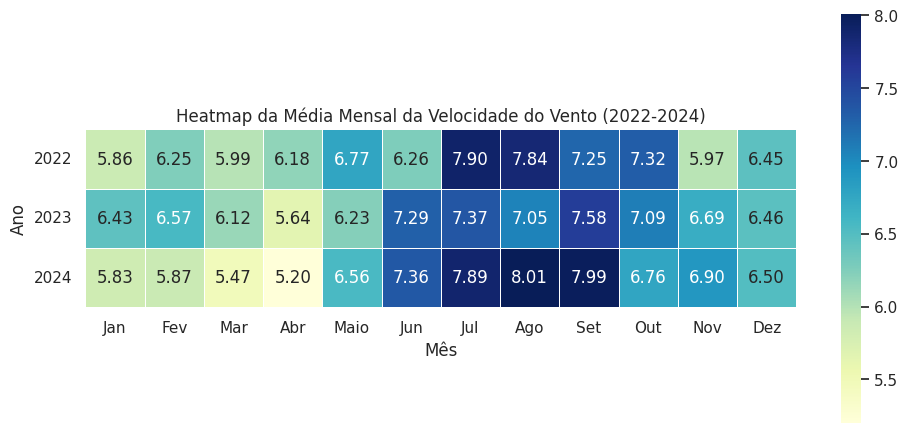

Heatmap salvo em: 
'/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50_heatmap_mensal.png'
--------------------------------------------------------------------------------


In [ ]:
# --- Define o diretório base ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

# --- Supondo que o DataFrame df_nasa já esteja carregado ---
try:
    df_nasa = pd.read_csv('/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/df_nasa.csv')
    if 'WS50M' in df_nasa.columns:
        df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')
except FileNotFoundError:
    print("Erro: df_nasa.csv não encontrado.")
    df_nasa = pd.DataFrame()
except Exception as e:
    print(f"Erro ao carregar df_nasa.csv: {e}")
    df_nasa = pd.DataFrame()

def plot_monthly_heatmap(dataframe, year_col, month_col, data_col, years_to_compare,
                         title, xlabel, ylabel, output_filename, cmap='YlGnBu', annot=True, fmt=".2f"):
    """
    Gera um heatmap da média mensal dos dados para os anos especificados.

    Args:
        dataframe (pd.DataFrame): DataFrame contendo os dados.
        year_col (str): Nome da coluna com o ano.
        month_col (str): Nome da coluna com o mês.
        data_col (str): Nome da coluna com os dados.
        years_to_compare (list): Lista de anos para comparar.
        title (str): Título do gráfico.
        xlabel (str): Rótulo do eixo x.
        ylabel (str): Rótulo do eixo y.
        output_filename (str): Nome do arquivo para salvar o gráfico.
        cmap (str, optional): Mapa de cores para o heatmap. Padrão é 'YlGnBu'.
        annot (bool, optional): Se True, exibe os valores nas células. Padrão é True.
        fmt (str, optional): Formato da anotação. Padrão é ".2f".
    """
    print('=' * 80)
    print(f"--- Gerando Heatmap da Média Mensal para os Anos \n({', '.join(map(str, years_to_compare))}) ---")
    print('=' * 80)

    full_output_filename = os.path.join(SAVE_BASE_DIR, output_filename)

    # Filtra o DataFrame para os anos especificados
    df_filtered = dataframe[dataframe[year_col].isin(years_to_compare)].copy()

    if df_filtered.empty:
        print("AVISO: Nenhum dado encontrado para os anos especificados.")
        return

    # Agrupa por ano e mês e calcula a média dos dados
    df_monthly_avg = df_filtered.groupby([year_col, month_col])[data_col].mean().reset_index()

    # Pivota a tabela para o formato adequado para o heatmap
    pivot_table = df_monthly_avg.pivot_table(index=year_col, columns=month_col, values=data_col)
    pivot_table = pivot_table.rename(columns={i: ['Jan', 'Fev', 'Mar', 'Abr', 'Maio', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'][i-1] for i in range(1, 13)})

    plt.figure(figsize=(10, len(years_to_compare) * 1.5)) # Ajusta a altura da figura baseado no número de anos
    sns.heatmap(pivot_table, cmap=cmap, square=True, annot=annot, fmt=fmt, linewidths=.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(rotation=0) # Garante que os anos fiquem na horizontal
    plt.tight_layout()
    plt.savefig(full_output_filename, dpi=300)
    plt.show()
    print(f"Heatmap salvo em: \n'{full_output_filename}'")
    print('-' * 80)

# --- Geração do Heatmap da Média Mensal ---
if not df_nasa.empty and 'YEAR' in df_nasa.columns and 'MO' in df_nasa.columns and 'WS50M' in df_nasa.columns:
    plot_monthly_heatmap(
        dataframe=df_nasa,
        year_col='YEAR',
        month_col='MO',
        data_col='WS50M',
        years_to_compare=[2022, 2023, 2024],
        title='Heatmap da Média Mensal da Velocidade do Vento (2022-2024)',
        xlabel='Mês',
        ylabel='Ano',
        output_filename='ws50_heatmap_mensal.png'
    )
else:
    print("Não foi possível gerar o heatmap: DataFrame 'df_nasa' está vazio ou colunas 'YEAR', 'MO' ou 'WS50M' não estão presentes.")
    print("-" * 80)

#### **Análise do Resultado Gráfico**

1. **Heatmap da Média Mensal de Velocidade do Vento (2022–2024)**

**Vantagens visuais:**

- O heatmap destaca rapidamente os meses mais ventosos (**`tons escuros`**) e os mais calmos (**`tons claros`**).

**Insights:**

- Julho e Agosto são os meses com maiores velocidades médias, próximos ou acima de **`7.9 m/s`** em todos os anos.

- Abril e Março são consistentemente os meses mais fracos, especialmente em 2024 (**`5.20 m/s em abril`**).

- O ano de 2024 mostra maior contraste intra-anual, com meses de vento muito fraco e muito forte.

- Os padrões visuais confirmam os dados do gráfico de linha, facilitando a identificação de padrões interanuais e mensais.

2. **Conclusão Integrada dos Dois Gráficos**

- Há forte sazonalidade na velocidade do vento, com máximos entre junho e setembro.

- 2024 apresentou maior amplitude anual, destacando-se tanto por ventos fracos no primeiro quadrimestre quanto por picos excepcionais no inverno.

- A análise multianual reforça a importância de considerar flutuações sazonais e interanuais na modelagem e planejamento energético.

- **Esses dados são altamente úteis para aplicações como:**

 - Previsões de geração eólica.

 - Planejamento de manutenção de turbinas (**`evitar meses críticos`**).

 - Análise climática regional.

---
## **ETAPA 4: ANÁLISE PREDITIVA**
---

---
### **PARTE 1 - PREPARAÇÃO DOS DADOS**
---

---
#### **Carregar bibliotecas e definir diretório:**
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import os
from tqdm.notebook import tqdm # Continuaremos usando para eventuais loops

In [ ]:
# --- Define o diretório base (ajuste se necessário) ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

---
### **PARTE 2 - ANÁLISE DE SAZONALIDADE ETENDÊNCIA:**
---

- Com os dados preparados, podemos avançar para a próxima etapa: Análise de Sazonalidade e Tendência utilizando a decomposição da série temporal. Isso é crucial para o **`SARIMA`**, pois nos ajuda a identificar os componentes de sazonalidade (**`S`**) e a ordem de diferenciação (**`D`**) necessária.

---
### **PARTE 3: IMPLEMENTAÇÃO DO MODELO HOLT-WINTERS:**
---

Série temporal diária 'WS50M' carregada e preparada.

--- ETAPA 3 (Revisada) - PARTE 1: Pré-tratamento para Granularidade Mensal ---
Série temporal agregada para média mensal. Dimensão: (533,)

Últimas 5 linhas da série temporal mensal:

DATE
2025-01-01    5.724194
2025-02-01    6.851786
2025-03-01    6.423226
2025-04-01    6.121333
2025-05-01    5.867083
Freq: MS, Name: WS50M, dtype: float64

--- ETAPA 3 (Revisada) - PARTE 2: Análise de Sazonalidade e Tendência (Mensal) ---


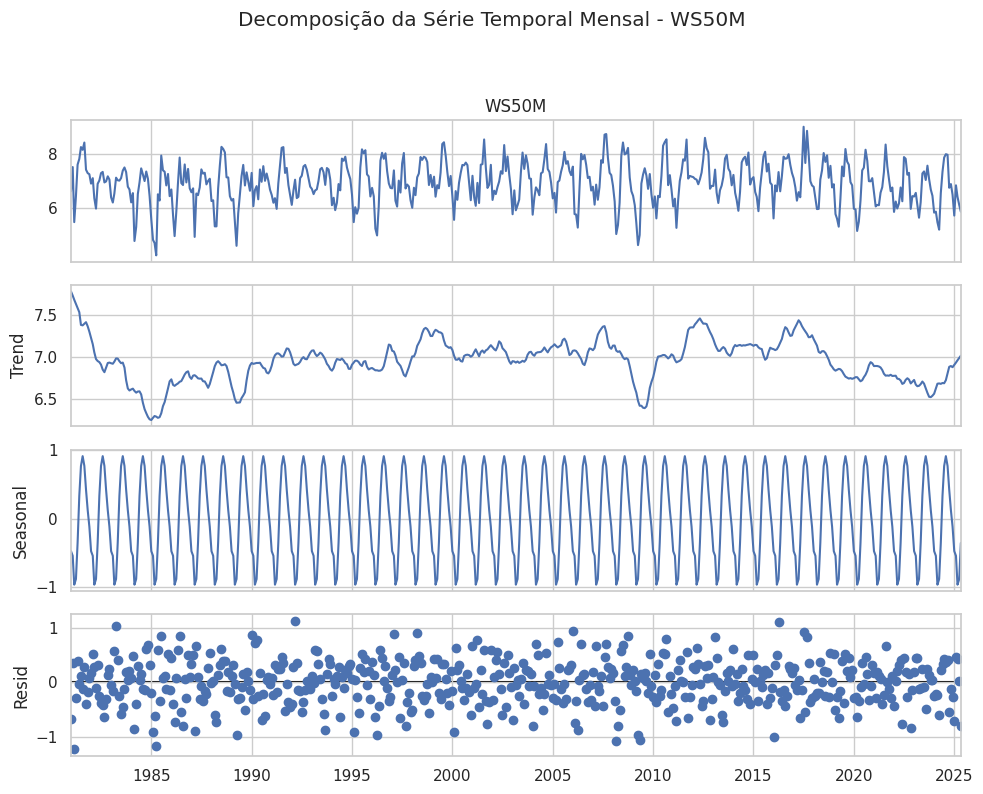

Gráfico de decomposição mensal salvo em: 
'/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50m_monthly_decomposition.png'

--- ETAPA 3 (Revisada) - PARTE 3: Implementação do Modelo Holt-Winters ---

Série mensal filtrada até 2024-12-31. Dimensão: (528,)
Tamanho do treino mensal: 516 (de 1981-01-01 00:00:00 a 2023-12-01 00:00:00)
Tamanho do teste mensal: 12 (de 2024-01-01 00:00:00 a 2024-12-01 00:00:00)

Ajustando modelo Holt-Winters...
Modelo Holt-Winters ajustado.
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    WS50M   No. Observations:                  516
Model:             ExponentialSmoothing   SSE                            107.334
Optimized:                         True   AIC                           -778.204
Trend:                         Additive   BIC                           -710.266
Seasonal:                 

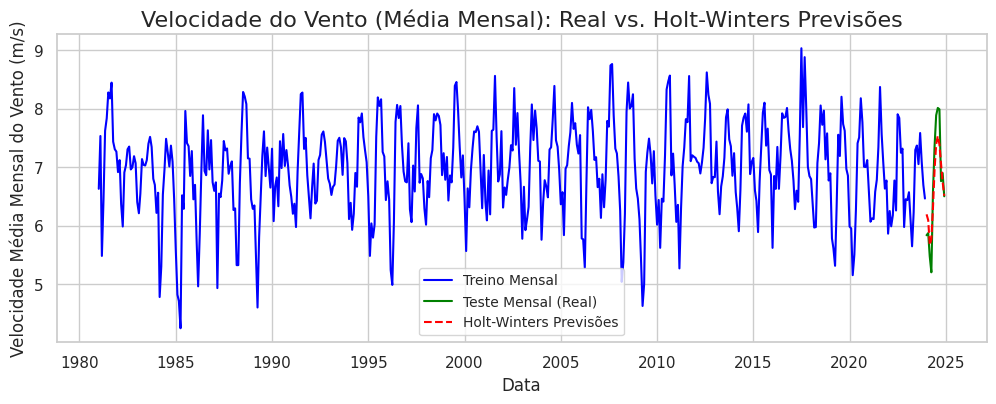

Gráfico de previsões Holt-Winters salvo em: 
'/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50m_holtwinters_predictions.png'

Retreinando Holt-Winters com dados mensais até o final de 2024 para prever 2025...
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    WS50M   No. Observations:                  528
Model:             ExponentialSmoothing   SSE                            109.066
Optimized:                         True   AIC                           -800.732
Trend:                         Additive   BIC                           -732.427
Seasonal:                      Additive   AICC                          -799.389
Seasonal Periods:                    12   Date:                 Sun, 01 Jun 2025
Box-Cox:                          False   Time:                         00:06:54
Box-Cox Coeff.:                    None   

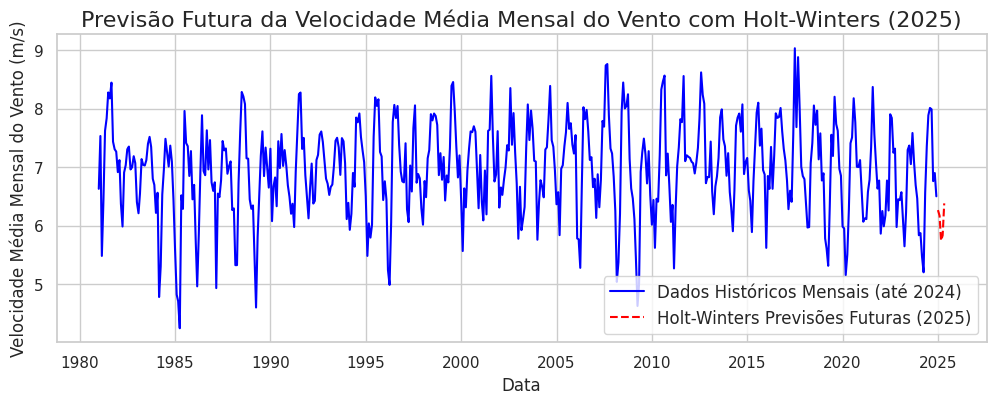

Gráfico de previsões futuras Holt-Winters salvo em: 
'/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50m_holtwinters_future_predictions.png'

--- Implementação do Modelo Holt-Winters Concluída ---


In [ ]:
# --- Carregar e preparar o DataFrame df_nasa.csv (se ts_data não estiver na memória) ---
try:
    df_nasa = pd.read_csv(os.path.join(SAVE_BASE_DIR, 'df_nasa.csv'))
    if 'WS50M' in df_nasa.columns:
        df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')
    if not df_nasa.empty:
        df_nasa['DATE_STR'] = df_nasa['YEAR'].astype(str) + '-' + \
                              df_nasa['MO'].astype(str).str.zfill(2) + '-' + \
                              df_nasa['DY'].astype(str).str.zfill(2)
        df_nasa['DATE'] = pd.to_datetime(df_nasa['DATE_STR'])
        df_nasa = df_nasa.set_index('DATE')
        df_nasa = df_nasa.drop(columns=['DATE_STR'])
        ts_data = df_nasa['WS50M'].dropna()
        ts_data = ts_data.asfreq('D')
        ts_data = ts_data.interpolate(method='linear', limit_direction='both', limit_area='inside')
        print("Série temporal diária 'WS50M' carregada e preparada.")
    else:
        ts_data = pd.Series()
except Exception as e:
    print(f"Erro ao carregar ou preparar df_nasa para Holt-Winters: {e}")
    ts_data = pd.Series()

# --- ETAPA 3 (Revisada) - PARTE 1: Pré-tratamento para Granularidade Mensal ---
print("\n--- ETAPA 3 (Revisada) - PARTE 1: Pré-tratamento para Granularidade Mensal ---")

if not ts_data.empty:
    # Agregação para média mensal
    ts_monthly_data = ts_data.resample('MS').mean() # 'MS' para o início do mês
    ts_monthly_data = ts_monthly_data.interpolate(method='linear', limit_direction='both', limit_area='inside') # Interpola se algum mês não tiver dado algum dia

    print(f"Série temporal agregada para média mensal. Dimensão: {ts_monthly_data.shape}")
    if ts_monthly_data.isnull().sum() > 0:
        print(f"Alerta: Ainda existem {ts_monthly_data.isnull().sum()} valores nulos após interpolação mensal.")
        ts_monthly_data = ts_monthly_data.fillna(method='ffill').fillna(method='bfill')
        print(f"Nulos após preenchimento adicional: {ts_monthly_data.isnull().sum()}")
    print("\nÚltimas 5 linhas da série temporal mensal:\n")
    print(ts_monthly_data.tail())

    # --- ETAPA 3 (Revisada) - PARTE 2: Análise de Sazonalidade e Tendência (Mensal) ---
    print("\n--- ETAPA 3 (Revisada) - PARTE 2: Análise de Sazonalidade e Tendência (Mensal) ---")
    if len(ts_monthly_data) >= 2*12: # Requer pelo menos 2 ciclos anuais (12 meses)
        decomposition_monthly = seasonal_decompose(ts_monthly_data, model='additive', period=12, extrapolate_trend='freq')
        fig = decomposition_monthly.plot()
        fig.set_size_inches(10, 8)
        plt.suptitle('Decomposição da Série Temporal Mensal - WS50M', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        decomp_monthly_filename = os.path.join(SAVE_BASE_DIR, 'ws50m_monthly_decomposition.png')
        plt.savefig(decomp_monthly_filename, dpi=300)
        plt.show()
        print(f"Gráfico de decomposição mensal salvo em: \n'{decomp_monthly_filename}'")
    else:
        print("Série mensal muito curta para decomposição com período 12.")

    # --- ETAPA 3 (Revisada) - PARTE 3: Implementação do Modelo Holt-Winters ---
    print("\n--- ETAPA 3 (Revisada) - PARTE 3: Implementação do Modelo Holt-Winters ---")

    # Filtrar dados até o final de 2024 para consistência
    ts_monthly_data_completa = ts_monthly_data[ts_monthly_data.index <= '2024-12-31']
    print(f"\nSérie mensal filtrada até 2024-12-31. Dimensão: {ts_monthly_data_completa.shape}")


    if len(ts_monthly_data_completa) > 12 : # Pelo menos 1 ano para teste
        # Dividir em treino e teste (últimos 12 meses para teste)
        train_monthly = ts_monthly_data_completa.iloc[:-12]
        test_monthly = ts_monthly_data_completa.iloc[-12:]

        print(f"Tamanho do treino mensal: {len(train_monthly)} (de {train_monthly.index.min()} a {train_monthly.index.max()})")
        print(f"Tamanho do teste mensal: {len(test_monthly)} (de {test_monthly.index.min()} a {test_monthly.index.max()})")

        # Ajustar o modelo Holt-Winters
        # 'add' para tendência aditiva, 'add' para sazonalidade aditiva, seasonal_periods=12 para anual
        try:
            print("\nAjustando modelo Holt-Winters...")
            model_hw = ExponentialSmoothing(train_monthly,
                                            trend='add',
                                            seasonal='add',
                                            seasonal_periods=12,
                                            initialization_method='estimated').fit() # 'heuristic', 'estimated', ou 'legacy-heuristic'

            print("Modelo Holt-Winters ajustado.")
            print(model_hw.summary())

            # Realizar previsões no conjunto de teste
            n_periods_test_monthly = len(test_monthly)
            predictions_hw = model_hw.forecast(steps=n_periods_test_monthly)
            predictions_hw_series = pd.Series(predictions_hw, index=test_monthly.index)

            # Avaliar desempenho
            rmse_hw = np.sqrt(mean_squared_error(test_monthly, predictions_hw_series))
            mae_hw = mean_absolute_error(test_monthly, predictions_hw_series)

            print(f"\n--- Avaliação do Modelo Holt-Winters (Mensal) ---")
            print(f"RMSE: {rmse_hw:.4f}")
            print(f"MAE:  {mae_hw:.4f}")

            # Plotar resultados
            plt.figure(figsize=(12, 4))
            plt.plot(train_monthly.index, train_monthly, label='Treino Mensal', color='blue')
            plt.plot(test_monthly.index, test_monthly, label='Teste Mensal (Real)', color='green')
            plt.plot(predictions_hw_series.index, predictions_hw_series, label='Holt-Winters Previsões', color='red', linestyle='--')
            plt.title('Velocidade do Vento (Média Mensal): Real vs. Holt-Winters Previsões', fontsize=16)
            plt.xlabel('Data', fontsize=12)
            plt.ylabel('Velocidade Média Mensal do Vento (m/s)', fontsize=12)
            plt.legend(fontsize=10)
            plt.grid(True)
            hw_plot_filename = os.path.join(SAVE_BASE_DIR, 'ws50m_holtwinters_predictions.png')
            plt.savefig(hw_plot_filename, dpi=300)
            plt.show()
            print(f"Gráfico de previsões Holt-Winters salvo em: \n'{hw_plot_filename}'")

            # Previsão futura com Holt-Winters (ex: próximos 12 meses)
            print("\nRetreinando Holt-Winters com dados mensais até o final de 2024 para prever 2025...")
            final_hw_model = ExponentialSmoothing(ts_monthly_data_completa, # Usar todos os dados mensais até 2024
                                                  trend='add',
                                                  seasonal='add',
                                                  seasonal_periods=12,
                                                  initialization_method='estimated').fit()
            print(final_hw_model.summary())

            # Prever os próximos meses de 2025 (ex: 5 meses para ir até maio)
            n_periods_future_monthly = 5 # Para ir até Maio de 2025
            future_predictions_hw = final_hw_model.forecast(steps=n_periods_future_monthly)
            future_index_monthly = pd.date_range(start='2025-01-01', periods=n_periods_future_monthly, freq='MS')
            future_predictions_hw_series = pd.Series(future_predictions_hw, index=future_index_monthly)

            plt.figure(figsize=(12, 4))
            plt.plot(ts_monthly_data_completa.index, ts_monthly_data_completa, label='Dados Históricos Mensais (até 2024)', color='blue')
            plt.plot(future_predictions_hw_series.index, future_predictions_hw_series, label='Holt-Winters Previsões Futuras (2025)', color='red', linestyle='--')
            plt.title('Previsão Futura da Velocidade Média Mensal do Vento com Holt-Winters (2025)', fontsize=16)
            plt.xlabel('Data', fontsize=12)
            plt.ylabel('Velocidade Média Mensal do Vento (m/s)', fontsize=12)
            plt.legend(fontsize=12)
            plt.grid(True)
            future_hw_plot_filename = os.path.join(SAVE_BASE_DIR, 'ws50m_holtwinters_future_predictions.png')
            plt.savefig(future_hw_plot_filename, dpi=300)
            plt.show()
            print(f"Gráfico de previsões futuras Holt-Winters salvo em: \n'{future_hw_plot_filename}'")

        except Exception as e:
            print(f"Ocorreu um erro durante a execução do Holt-Winters: {e}")

    else:
        print("Não há dados suficientes na série mensal para o modelo Holt-Winters.")
else:
    print("Série temporal diária 'WS50M' está vazia, não é possível prosseguir com Holt-Winters.")

print("\n--- Implementação do Modelo Holt-Winters Concluída ---")

---
### **PARTE 4 - INTEGRANDO MACHINE LEARNING**
---

- Agora que temos um bom modelo de base com **`Holt-Winters`**, podemos explorar a integração com Machine Learning.
- A ideia é usar features da série temporal para treinar um modelo de regressão, como o **`Random Forest`**.

1. Treinamento e Avaliação do Modelo Random Forest Regressor:


--- ETAPA 3 (Revisada) - PARTE 4: Engenharia de Features para Machine Learning ---
DataFrame para ML criado com features. Dimensão após dropna: (516, 17)

Primeiras 5 linhas do DataFrame para ML (df_ml_cleaned):
               WS50M  WS50M_lag_1  WS50M_lag_2  WS50M_lag_3  WS50M_lag_4  \
DATE                                                                       
1982-01-01  6.914194     7.264839     7.305333     7.434839     8.445333   
1982-02-01  7.119286     6.914194     7.264839     7.305333     7.434839   
1982-03-01  6.372258     7.119286     6.914194     7.264839     7.305333   
1982-04-01  5.983667     6.372258     7.119286     6.914194     7.264839   
1982-05-01  6.907419     5.983667     6.372258     7.119286     6.914194   

            WS50M_lag_5  WS50M_lag_6  WS50M_lag_7  WS50M_lag_8  WS50M_lag_9  \
DATE                                                                          
1982-01-01     8.174194     8.276774     7.836000     7.622258     6.451000   
1982-02-01     8.

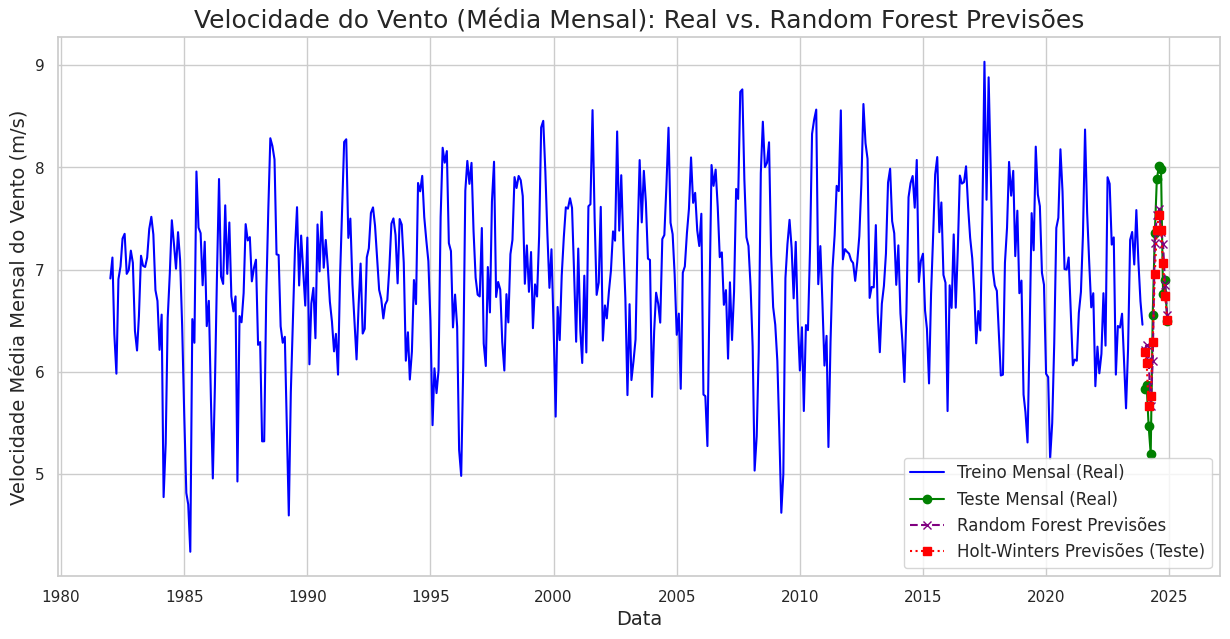

Gráfico de previsões Random Forest salvo em: 
'/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50m_randomforest_predictions.png'


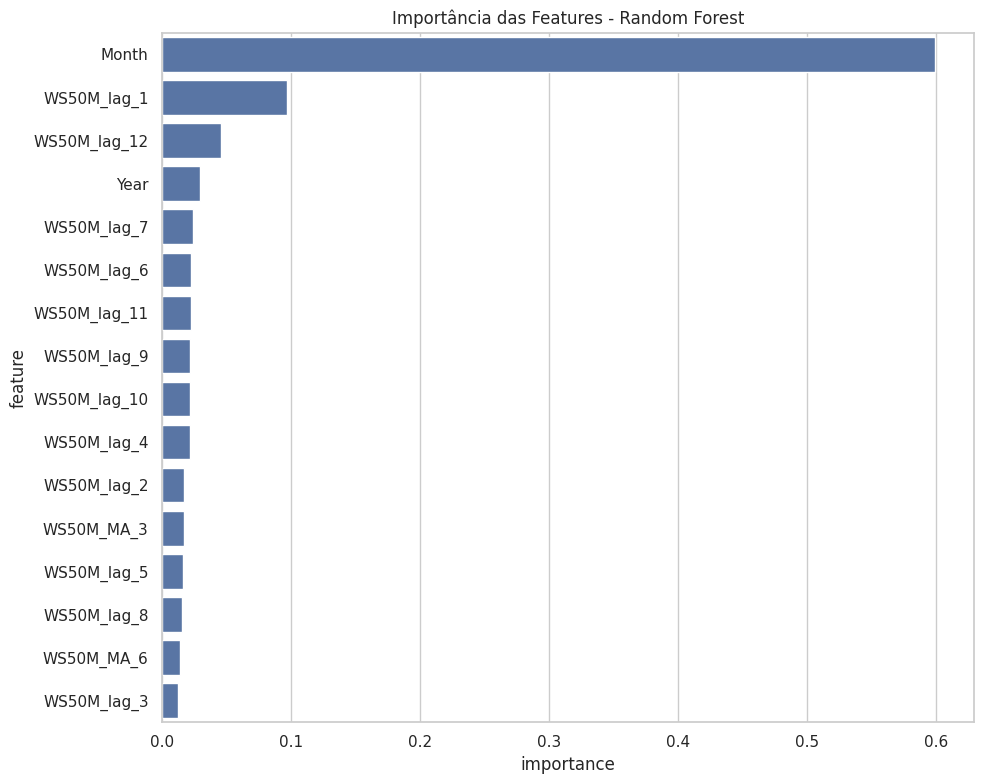

Gráfico de importância das features salvo em: 
'/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50m_rf_feature_importance.png'

Importância das Features:
         feature  importance
14         Month    0.599391
0    WS50M_lag_1    0.097021
11  WS50M_lag_12    0.046123
15          Year    0.029719
6    WS50M_lag_7    0.024399
5    WS50M_lag_6    0.022572
10  WS50M_lag_11    0.022266
8    WS50M_lag_9    0.021847
9   WS50M_lag_10    0.021580
3    WS50M_lag_4    0.021420
1    WS50M_lag_2    0.017405
12    WS50M_MA_3    0.017251
4    WS50M_lag_5    0.016716
7    WS50M_lag_8    0.015729
13    WS50M_MA_6    0.013703
2    WS50M_lag_3    0.012859

--- Implementação do Modelo Random Forest Concluída ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import os
from tqdm.notebook import tqdm

# --- Define o diretório base (ajuste se necessário) ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

# --- Carregar e preparar o DataFrame df_nasa.csv (se ts_data e ts_monthly_data_completa não estiverem na memória) ---
# Esta parte assume que ts_monthly_data_completa já foi criada e está disponível
# Se não, descomente e ajuste o bloco de carregamento e agregação mensal anterior.

# try:
#     df_nasa = pd.read_csv(os.path.join(SAVE_BASE_DIR, 'df_nasa.csv'))
#     if 'WS50M' in df_nasa.columns:
#         df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')

#     if not df_nasa.empty:
#         df_nasa['DATE_STR'] = df_nasa['YEAR'].astype(str) + '-' + \
#                               df_nasa['MO'].astype(str).str.zfill(2) + '-' + \
#                               df_nasa['DY'].astype(str).str.zfill(2)
#         df_nasa['DATE'] = pd.to_datetime(df_nasa['DATE_STR'])
#         df_nasa = df_nasa.set_index('DATE')
#         df_nasa = df_nasa.drop(columns=['DATE_STR'])
#         ts_data = df_nasa['WS50M'].dropna()
#         ts_data = ts_data.asfreq('D')
#         ts_data = ts_data.interpolate(method='linear', limit_direction='both', limit_area='inside')

#         ts_monthly_data = ts_data.resample('MS').mean()
#         ts_monthly_data = ts_monthly_data.interpolate(method='linear', limit_direction='both', limit_area='inside')
#         ts_monthly_data_completa = ts_monthly_data[ts_monthly_data.index <= '2024-12-31']
#         print("Série temporal mensal 'ts_monthly_data_completa' carregada e preparada.")
#     else:
#         ts_monthly_data_completa = pd.Series()
# except Exception as e:
#     print(f"Erro ao carregar ou preparar df_nasa para Random Forest: {e}")
#     ts_monthly_data_completa = pd.Series()


# --- ETAPA 3 (Revisada) - PARTE 4: Engenharia de Features para Machine Learning ---
print("\n--- ETAPA 3 (Revisada) - PARTE 4: Engenharia de Features para Machine Learning ---")

if not ts_monthly_data_completa.empty:
    df_ml = ts_monthly_data_completa.to_frame().copy() # Converter para DataFrame se for uma Série

    # 1. Criar Lags (Valores Atrasados)
    # Usaremos lags de 1 a 12 meses, pois há uma forte sazonalidade anual (12 meses)
    for i in range(1, 13):
        df_ml[f'WS50M_lag_{i}'] = df_ml['WS50M'].shift(i)

    # 2. Criar Médias Móveis
    # Média móvel dos últimos 3 e 6 meses (excluindo o mês atual da média, por isso o shift(1))
    df_ml['WS50M_MA_3'] = df_ml['WS50M'].rolling(window=3).mean().shift(1)
    df_ml['WS50M_MA_6'] = df_ml['WS50M'].rolling(window=6).mean().shift(1)

    # 3. Criar Features de Data
    df_ml['Month'] = df_ml.index.month
    df_ml['Year'] = df_ml.index.year # Pode ajudar a capturar tendências de longo prazo

    # 4. Remover NaNs gerados pelos lags e médias móveis
    df_ml_cleaned = df_ml.dropna()

    print(f"DataFrame para ML criado com features. Dimensão após dropna: {df_ml_cleaned.shape}")
    print("\nPrimeiras 5 linhas do DataFrame para ML (df_ml_cleaned):")
    print(df_ml_cleaned.head())
    print("\nÚltimas 5 linhas do DataFrame para ML (df_ml_cleaned):")
    print(df_ml_cleaned.tail())


    # --- ETAPA 3 (Revisada) - PARTE 5: Treinamento e Avaliação do Random Forest Regressor ---
    print("\n--- ETAPA 3 (Revisada) - PARTE 5: Treinamento e Avaliação do Random Forest Regressor ---")

    if not df_ml_cleaned.empty:
        # Definir Features (X) e Alvo (y)
        # O alvo é a velocidade do vento atual ('WS50M')
        # As features são os lags, médias móveis e componentes de data
        target_column = 'WS50M'
        feature_columns = [col for col in df_ml_cleaned.columns if col != target_column]

        X = df_ml_cleaned[feature_columns]
        y = df_ml_cleaned[target_column]

        # Dividir em treino e teste
        # Usaremos o mesmo período de teste de 2024 (últimos 12 meses dos dados limpos)
        # df_ml_cleaned termina em 2024-12-01 por causa do shift(1) na MA_6
        # Ajuste para garantir que test_monthly_ml tenha 12 observações se possível

        if len(df_ml_cleaned) > 12:
            X_train_ml = X.iloc[:-12]
            X_test_ml = X.iloc[-12:]
            y_train_ml = y.iloc[:-12]
            y_test_ml = y.iloc[-12:]

            print(f"\nTamanho do treino ML (X_train_ml): {X_train_ml.shape}, (y_train_ml): {y_train_ml.shape}")
            print(f"Tamanho do teste ML (X_test_ml): {X_test_ml.shape}, (y_test_ml): {y_test_ml.shape}")
            print(f"Período de treino ML: de {X_train_ml.index.min()} a {X_train_ml.index.max()}")
            print(f"Período de teste ML: de {X_test_ml.index.min()} a {X_test_ml.index.max()}")


            # Treinar o modelo Random Forest Regressor
            print("\nAjustando modelo Random Forest Regressor...")
            # Pode-se usar GridSearchCV para encontrar os melhores hiperparâmetros,
            # mas para um primeiro teste, usaremos valores padrão ou alguns definidos.
            rf_model = RandomForestRegressor(n_estimators=100, # Número de árvores
                                             random_state=42,   # Para reprodutibilidade
                                             n_jobs=-1,         # Usar todos os processadores disponíveis
                                             max_depth=10,      # Profundidade máxima das árvores
                                             min_samples_split=5,# Mínimo de amostras para dividir um nó
                                             min_samples_leaf=3) # Mínimo de amostras por folha

            rf_model.fit(X_train_ml, y_train_ml)
            print("Modelo Random Forest ajustado.")

            # Realizar previsões no conjunto de teste
            predictions_rf = rf_model.predict(X_test_ml)
            predictions_rf_series = pd.Series(predictions_rf, index=y_test_ml.index)

            # Avaliar desempenho
            rmse_rf = np.sqrt(mean_squared_error(y_test_ml, predictions_rf_series))
            mae_rf = mean_absolute_error(y_test_ml, predictions_rf_series)

            print(f"\n--- Avaliação do Modelo Random Forest (Mensal) ---")
            print(f"RMSE: {rmse_rf:.4f}")
            print(f"MAE:  {mae_rf:.4f}")

            # Plotar resultados
            plt.figure(figsize=(15, 7))
            # Plotar os dados de treino originais (sem features) para melhor visualização da série
            plt.plot(ts_monthly_data_completa.loc[X_train_ml.index].index, y_train_ml, label='Treino Mensal (Real)', color='blue')
            plt.plot(y_test_ml.index, y_test_ml, label='Teste Mensal (Real)', color='green', marker='o')
            plt.plot(predictions_rf_series.index, predictions_rf_series, label='Random Forest Previsões', color='purple', linestyle='--', marker='x')

            # Adicionar previsões Holt-Winters do passo anterior para comparação, se disponíveis
            # Isso requer que 'predictions_hw_series' esteja no escopo.
            # Se você rodou a célula Holt-Winters antes desta, ela deve estar.
            try:
                if 'predictions_hw_series' in globals() and not predictions_hw_series.empty:
                     # Certifique-se que os índices coincidam para plotagem correta
                    hw_test_predictions_to_plot = predictions_hw_series[predictions_hw_series.index.isin(y_test_ml.index)]
                    if not hw_test_predictions_to_plot.empty:
                        plt.plot(hw_test_predictions_to_plot.index, hw_test_predictions_to_plot, label='Holt-Winters Previsões (Teste)', color='red', linestyle=':', marker='s')
            except NameError:
                print("Variável 'predictions_hw_series' (previsões Holt-Winters no teste) não encontrada para plotagem comparativa.")


            plt.title('Velocidade do Vento (Média Mensal): Real vs. Random Forest Previsões', fontsize=18)
            plt.xlabel('Data', fontsize=14)
            plt.ylabel('Velocidade Média Mensal do Vento (m/s)', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True)
            rf_plot_filename = os.path.join(SAVE_BASE_DIR, 'ws50m_randomforest_predictions.png')
            plt.savefig(rf_plot_filename, dpi=300)
            plt.show()
            print(f"Gráfico de previsões Random Forest salvo em: \n'{rf_plot_filename}'")

            # Feature Importances (Opcional, mas útil)
            importances = rf_model.feature_importances_
            feature_importance_df = pd.DataFrame({'feature': feature_columns, 'importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=feature_importance_df)
            plt.title('Importância das Features - Random Forest')
            plt.tight_layout()
            rf_importance_filename = os.path.join(SAVE_BASE_DIR, 'ws50m_rf_feature_importance.png')
            plt.savefig(rf_importance_filename, dpi=300)
            plt.show()
            print(f"Gráfico de importância das features salvo em: \n'{rf_importance_filename}'")
            print("\nImportância das Features:")
            print(feature_importance_df)

        else:
            print("Não há dados suficientes após limpeza para treinar/testar o modelo de ML.")
    else:
        print("DataFrame para ML (df_ml_cleaned) está vazio.")
else:
    print("Série temporal mensal 'ts_monthly_data_completa' está vazia, não é possível prosseguir com Random Forest.")

print("\n--- Implementação do Modelo Random Forest Concluída ---")

---
### **PARTE 5 - Previsão Futura com Random Forest (Recursiva):**
---

 - Como mencionado antes, para prever 2025, você precisaria treinar o modelo com dados até o final de 2024 e, em seguida, prever mês a mês, alimentando a previsão de volta como um lag para o próximo passo.

  - **Código para previsão futura recursiva (exemplo para 5 meses de 2025):**


--- ETAPA 3 (Revisada) - PARTE 6: Previsão Futura com Random Forest (Recursiva) ---

Ajustando modelo Random Forest final com todos os dados disponíveis...
Modelo Random Forest final ajustado.

Iniciando previsão futura recursiva...


Prevendo meses futuros:   0%|          | 0/5 [00:00<?, ?it/s]

Previsão futura recursiva concluída.


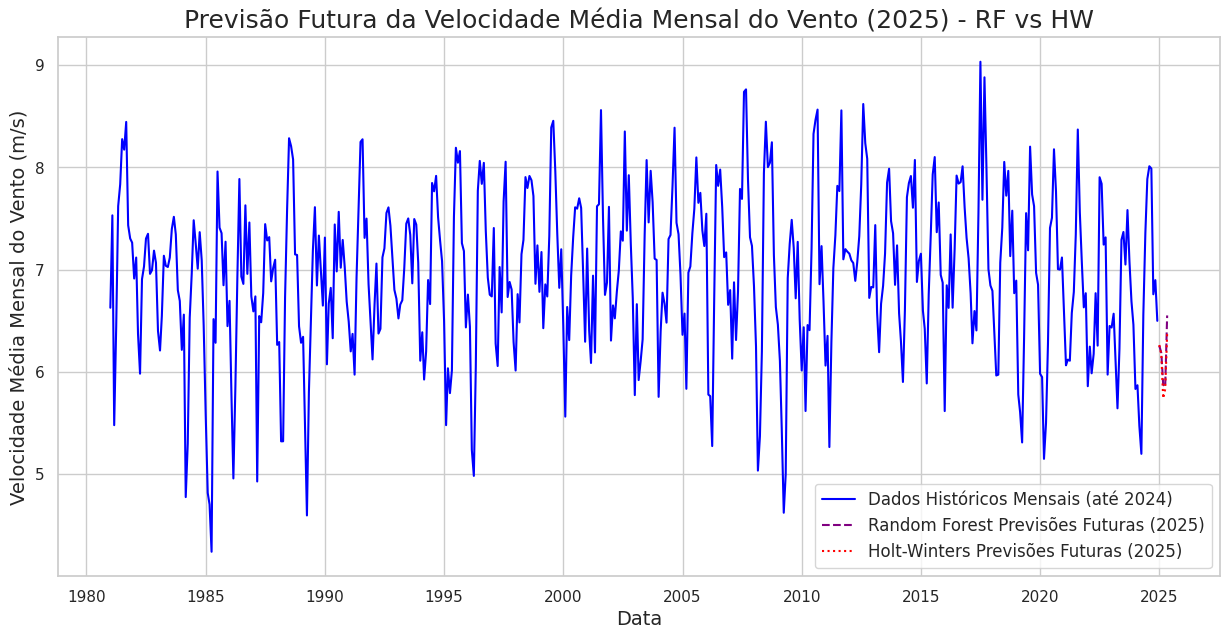

Gráfico de previsões futuras Random Forest salvo em: '/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/ws50m_rf_future_predictions.png'

Previsões Futuras (Janeiro a Maio de 2025) - Random Forest:
2025-01-01    6.257006
2025-02-01    6.184379
2025-03-01    5.877831
2025-04-01    5.858282
2025-05-01    6.553053
Freq: MS, dtype: float64


In [ ]:
# --- ETAPA 3 (Revisada) - PARTE 6: Previsão Futura com Random Forest (Recursiva) ---
print("\n--- ETAPA 3 (Revisada) - PARTE 6: Previsão Futura com Random Forest (Recursiva) ---")

# Retreinar o modelo com todos os dados limpos disponíveis (até 2024-12-01)
X_full_ml = df_ml_cleaned[feature_columns]
y_full_ml = df_ml_cleaned[target_column]

print("\nAjustando modelo Random Forest final com todos os dados disponíveis...")
rf_model_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,
                                     max_depth=10, min_samples_split=5, min_samples_leaf=3)
rf_model_final.fit(X_full_ml, y_full_ml)
print("Modelo Random Forest final ajustado.")

# Preparar para previsão recursiva
n_future_periods = 5 # Jan a Mai de 2025
last_date_in_data = df_ml_cleaned.index[-1]
future_dates = pd.date_range(start=last_date_in_data + pd.DateOffset(months=1), periods=n_future_periods, freq='MS')

# Última linha de dados conhecidos para iniciar a criação de features
last_known_features_df = df_ml_cleaned.iloc[[-1]][feature_columns].copy()
# A última linha de WS50M real para iniciar os lags
history_for_lags = df_ml_cleaned['WS50M'].copy()

future_predictions_rf_list = []

print("\nIniciando previsão futura recursiva...")
for current_date in tqdm(future_dates, desc="Prevendo meses futuros"):
    # Criar features para a data atual
    current_features = {}

    # Lags (usando a série 'history_for_lags' que será atualizada)
    for i in range(1, 13):
        if len(history_for_lags) >= i:
            current_features[f'WS50M_lag_{i}'] = [history_for_lags.iloc[-i]]
        else: # Caso não haja histórico suficiente para o lag
            current_features[f'WS50M_lag_{i}'] = [np.nan] # Ou outra estratégia de preenchimento

    # Médias Móveis (usando a série 'history_for_lags')
    if len(history_for_lags) >= 3:
        current_features['WS50M_MA_3'] = [history_for_lags.iloc[-3:].mean()]
    else:
        current_features['WS50M_MA_3'] = [np.nan]

    if len(history_for_lags) >= 6:
        current_features['WS50M_MA_6'] = [history_for_lags.iloc[-6:].mean()]
    else:
        current_features['WS50M_MA_6'] = [np.nan]

    current_features['Month'] = [current_date.month]
    current_features['Year'] = [current_date.year]

    current_features_df = pd.DataFrame(current_features, index=[current_date])

    # Garantir que a ordem das colunas é a mesma do treino e preencher NaNs se necessário
    # (para MAs no início da previsão)
    current_features_df = current_features_df[feature_columns]
    # Estratégia simples de preenchimento de NaN para MAs nas primeiras previsões: usar o último lag
    for col in ['WS50M_MA_3', 'WS50M_MA_6']:
        if current_features_df[col].isnull().any():
            current_features_df[col] = current_features_df['WS50M_lag_1']


    # Fazer a previsão para a data atual
    prediction = rf_model_final.predict(current_features_df)[0]
    future_predictions_rf_list.append(prediction)

    # Adicionar a previsão ao histórico para ser usada nos próximos lags/MAs
    new_data_point = pd.Series([prediction], index=[current_date])
    history_for_lags = pd.concat([history_for_lags, new_data_point])

future_predictions_rf_series = pd.Series(future_predictions_rf_list, index=future_dates)
print("Previsão futura recursiva concluída.")

# Plotar previsões futuras do Random Forest
plt.figure(figsize=(15, 7))
plt.plot(ts_monthly_data_completa.index, ts_monthly_data_completa, label='Dados Históricos Mensais (até 2024)', color='blue')
plt.plot(future_predictions_rf_series.index, future_predictions_rf_series, label='Random Forest Previsões Futuras (2025)', color='purple', linestyle='--')

# Plotar previsões Holt-Winters futuras para comparação, se disponíveis
try:
    if 'future_predictions_hw_series' in globals() and not future_predictions_hw_series.empty:
        hw_future_to_plot = future_predictions_hw_series[future_predictions_hw_series.index.isin(future_dates)]
        if not hw_future_to_plot.empty:
             plt.plot(hw_future_to_plot.index, hw_future_to_plot, label='Holt-Winters Previsões Futuras (2025)', color='red', linestyle=':')
except NameError:
    print("Variável 'future_predictions_hw_series' não encontrada para plotagem comparativa.")

plt.title('Previsão Futura da Velocidade Média Mensal do Vento (2025) - RF vs HW', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Velocidade Média Mensal do Vento (m/s)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
future_rf_plot_filename = os.path.join(SAVE_BASE_DIR, 'ws50m_rf_future_predictions.png')
plt.savefig(future_rf_plot_filename, dpi=300)
plt.show()
print(f"Gráfico de previsões futuras Random Forest salvo em: '{future_rf_plot_filename}'")

print("\nPrevisões Futuras (Janeiro a Maio de 2025) - Random Forest:")
print(future_predictions_rf_series)

---
#### **ANÁLISE DOS RESULTADOS**
---

- Vamos analisar esses resultados e compará-los com o que obtivemos do Holt-Winters.


<H3><b>Análise dos Resultados da Previsão Futura com Random Forest (Mensal)</b>

---

1. **Desempenho do Modelo Random Forest (no conjunto de teste de 2024):**

 - **RMSE:** **`0.4158 m/s`**

 - **MAE:** **`0.3675 m/s`**

- Comparando com o Holt-Winters (**`RMSE: 0.3776, MAE: 0.3363`**), o Random Forest teve um desempenho ligeiramente inferior no conjunto de teste. Isso pode indicar que, para esta série e com a engenharia de features atual, o Holt-Winters, que é especializado em tendência e sazonalidade, conseguiu uma generalização um pouco melhor.

2. **Importância das Features no Random Forest:**

 - Conforme o gráfico de importância (**`image_713ebb.png`**), o Mês foi, de longe, a feature mais impactante (**`influência de ~59.9%`**).

 - Seguido por WS50M_lag_1 (**`~9.7%`**) e WS50M_lag_12 (**`~4.6%`**), e Year (**`~2.9%`**).

 - Isso reforça a forte influência da sazonalidade anual e da autocorrelação de curto e longo prazo na velocidade do vento.

3. **Previsões (Janeiro a Maio de 2025) - Random Forest:**

|MESES           |PREVISÕES     |
|----------------|--------------|
| Janeiro 2025   | 6.257006 m/s |
| Fevereiro 2025 | 6.184379 m/s |
| Março 2025     | 5.877831 m/s |
| Abril 2025     | 5.858282 m/s |
| Maio 2025      | 6.553053 m/s |

---
<H3><b>Comparação das Previsões Futuras (Holt-Winters vs. Random Forest)</b>

---

```
Mês (2025)   Holt-Winters (Aditivo)  Random Forest (Recursivo) Diferença (RF - HW)
Janeiro	  6.227370	            6.257006                  +0.029636
Fevereiro	6.171319	            6.184379                  +0.013060
Março	    5.817726                5.877831                  +0.060105
Abril	    5.832142                5.858282                  +0.026140
Maio	     6.491266                6.553053	              +0.061787
```

**Observações da Comparação:**

 - As previsões dos dois modelos para os primeiros 5 meses de 2025 são notavelmente próximas.

 - O Random Forest consistentemente previu valores ligeiramente mais altos que o Holt-Winters para este período, embora as diferenças sejam pequenas (**`na ordem de 0.01 a 0.06 m/s`**).

 - Ambos os modelos seguem o padrão sazonal esperado, com velocidades mais baixas em **`março/abril`** e uma recuperação em maio.

 - O gráfico de previsão futura gerado pelo código do Random Forest (**`que também incluiu as previsões do Holt-Winters`**) deve ter ilustrado bem essa similaridade e as pequenas diferenças.

**Conclusões e Próximos Passos**

 - Foi implementada com sucesso duas abordagens diferentes para a previsão da velocidade do vento: **`Holt-Winters`** (um método clássico de séries temporais) e **`Random Forest`** (um método de Machine Learning).

 - **`Holt-Winters`** se mostrou ligeiramente mais preciso no conjunto de teste de 2024, o que é esperado, dado seu design para capturar tendência e sazonalidade de forma explícita.

 - **`Random Forest`** forneceu previsões muito próximas e uma análise útil da importância das features, destacando a dominância da sazonalidade mensal.

 - A proximidade das previsões futuras dos dois modelos dá uma certa confiança no padrão sazonal projetado para o início de 2025.


---
## **RECOMENDAÇÕES E ESTUDOS FUTUROS**
---

**Sugestões para Etapas Futuras (conforme seu roteiro original):**

1. **Ajuste Fino dos Modelos:**

 - **Random Forest:** Realizar um GridSearchCV ou RandomizedSearchCV para otimizar os hiperparâmetros do Random Forest. Isso pode melhorar seu desempenho e potencialmente superar o Holt-Winters.

 - **Holt-Winters:** Embora o ExponentialSmoothing já otimize os parâmetros de suavização, você poderia experimentar com trend='mul' ou seasonal='mul' se a decomposição ou análise de resíduos sugerir que esses componentes são multiplicativos (`embora o aditivo pareça ter funcionado bem`).

2. **Engenharia de Features Avançada para ML:**

 - Incluir os componentes de tendência e sazonalidade da decomposição da série mensal como features para o Random Forest.
Utilizar features cíclicas para o mês (`seno/cosseno`) como sugerido anteriormente.

 - Testar outros algoritmos de ML (`Gradient Boosting como XGBoost ou LightGBM, ou até mesmo modelos mais simples como Regressão Linear com features polinomiais se a relação não for puramente linear`).

3. **Combinação dos Modelos (Passo 6 do seu roteiro):**

 - **Média Simples ou Ponderada:** Como as previsões foram próximas, uma média simples ou ponderada (`dando um peso ligeiramente maior ao Holt-Winters com base no RMSE/MAE do teste`) poderia ser uma forma robusta de combinar as previsões.

 - **Empilhamento (Stacking):** Para uma abordagem mais sofisticada, você poderia usar as previsões do Holt-Winters e do Random Forest (`no conjunto de teste/validação`) como entrada para um "meta-modelo" (`ex: uma regressão linear simples`) que aprenderia a melhor forma de combiná-las.

4. **Análise de Resíduos dos Modelos Preditivos:**

 - Analisar os resíduos das previsões de ambos os modelos no conjunto de teste. Se houver padrões (`autocorrelação, heterocedasticidade`), isso pode indicar oportunidades de melhoria ou a necessidade de modelos mais complexos.

---
## **DICIONÁRIO DOS DADOS**
---

**Este dicionário descreve as variáveis utilizadas neste estudo, provenientes da base de dados NASA POWER DAV e as features criadas durante a análise.**

1. **Dados Originais da NASA POWER DAV (df_nasa.csv):**
 - YEAR: Ano da observação.
    - Tipo: Numérico (Inteiro)
    - Exemplo: 1981, 2023
 - MO: Mês da observação.
    - Tipo: Numérico (Inteiro)
    - Exemplo: 1 (Janeiro), 12 (Dezembro)
 - DY: Dia da observação.
    - Tipo: Numérico (Inteiro)
    - Exemplo: 1, 15, 31
 - WS50M: Velocidade do Vento a 50 metros de altitude.
    - Tipo: Numérico (Ponto Flutuante)
    - Unidade: Metros por segundo (m/s)
 - Descrição: Principal variável de interesse, representando a
    - velocidade do vento na altitude especificada, utilizada para análises de potencial eólico e modelagem preditiva.

2. **Variáveis Criadas (Série Temporal Diária - ts_data):**
 - DATE (Índice): Data da observação.
    - Tipo: Datetime
    - Formato: YYYY-MM-DD
    - Descrição: Coluna de data unificada criada a partir das colunas YEAR, MO, DY e definida como índice da série temporal.
 - WS50M (Valor da Série): Velocidade do Vento a 50 metros de altitude (mesma que a original, mas agora como parte de uma série temporal indexada por data).
    - Tipo: Numérico (Ponto Flutuante)
    - Unidade: m/s

3. **Variáveis Criadas (Série Temporal Mensal - ts_monthly_data_completa):**
 - DATE (Índice): Primeiro dia do mês da observação agregada.
    - Tipo: Datetime
    - Formato: YYYY-MM-01
 - Descrição: Índice da série temporal após reamostragem dos dados diários para médias mensais.
 - WS50M (Valor da Série): Média mensal da velocidade do vento a 50 metros de altitude.
    - Tipo: Numérico (Ponto Flutuante)
    - Unidade: m/s

4. **Features Criadas para Modelagem de Machine Learning (em df_ml_cleaned):**
 - WS50M (Alvo): Média mensal da velocidade do vento a 50 metros de altitude (a variável que se deseja prever).
    - Tipo: Numérico (Ponto Flutuante)
 - WS50M_lag_X: Valor da velocidade média mensal do vento de X meses anteriores.
    - Tipo: Numérico (Ponto Flutuante)
    - Descrição: Utilizado como feature para capturar a autocorrelação da série. Foram criados lags de 1 a 12 meses (ex: WS50M_lag_1, WS50M_lag_12).
 - WS50M_MA_X: Média móvel da velocidade do vento dos últimos X meses (excluindo o mês atual).
    - Tipo: Numérico (Ponto Flutuante)
    - Descrição: Utilizado como feature para suavizar ruídos e capturar tendências de curto/médio prazo. Foram criadas MAs de 3 e 6 meses (ex: WS50M_MA_3).
 - Month: Mês da observação como uma feature numérica.
    - Tipo: Numérico (Inteiro)
    - Valores: 1 a 12
    - Descrição: Utilizado para capturar padrões sazonais anuais.
 - Year: Ano da observação como uma feature numérica.
    - Tipo: Numérico (Inteiro)
    - Descrição: Utilizado para capturar tendências de longo prazo ou variações interanuais.

5. **Componentes da Decomposição da Série Temporal (Exemplo para decomposition_monthly):**
 - Observed: A série temporal original (média mensal de WS50M).
    - Tipo: Numérico (Ponto Flutuante)
 - Trend: Componente de tendência da série.
    - Tipo: Numérico (Ponto Flutuante)
    - Descrição: Representa a direção geral da série ao longo do tempo, após a remoção da sazonalidade e ruído.
 - Seasonal: Componente de sazonalidade da série.
    - Tipo: Numérico (Ponto Flutuante)
    - Descrição: Representa o padrão que se repete em intervalos fixos (neste caso, anualmente, com período 12 para dados mensais).
- Resid: Componente residual (ou ruído) da série.
    - Tipo: Numérico (Ponto Flutuante)
    - Descrição: O que sobra após a remoção dos componentes de tendência e sazonalidade; idealmente, deve ser um ruído branco.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import os
from tqdm.notebook import tqdm

# --- Define o diretório base (ajuste se necessário) ---
SAVE_BASE_DIR = "/content/drive/MyDrive/Acadêmico/Graduação - Ciência de Dados CS - 2024/19 - Visualização da Informação - Turma_001/projeto_visualizacao/"
os.makedirs(SAVE_BASE_DIR, exist_ok=True)

# --- Carregar e preparar o DataFrame df_nasa.csv (se ts_data e ts_monthly_data_completa não estiverem na memória) ---
# Esta parte assume que ts_monthly_data_completa já foi criada e está disponível
# Se não, descomente e ajuste o bloco de carregamento e agregação mensal anterior.

# try:
#     df_nasa = pd.read_csv(os.path.join(SAVE_BASE_DIR, 'df_nasa.csv'))
#     if 'WS50M' in df_nasa.columns:
#         df_nasa['WS50M'] = pd.to_numeric(df_nasa['WS50M'], errors='coerce')

#     if not df_nasa.empty:
#         df_nasa['DATE_STR'] = df_nasa['YEAR'].astype(str) + '-' + \
#                               df_nasa['MO'].astype(str).str.zfill(2) + '-' + \
#                               df_nasa['DY'].astype(str).str.zfill(2)
#         df_nasa['DATE'] = pd.to_datetime(df_nasa['DATE_STR'])
#         df_nasa = df_nasa.set_index('DATE')
#         df_nasa = df_nasa.drop(columns=['DATE_STR'])
#         ts_data = df_nasa['WS50M'].dropna()
#         ts_data = ts_data.asfreq('D')
#         ts_data = ts_data.interpolate(method='linear', limit_direction='both', limit_area='inside')

#         ts_monthly_data = ts_data.resample('MS').mean()
#         ts_monthly_data = ts_monthly_data.interpolate(method='linear', limit_direction='both', limit_area='inside')
#         ts_monthly_data_completa = ts_monthly_data[ts_monthly_data.index <= '2024-12-31']
#         print("Série temporal mensal 'ts_monthly_data_completa' carregada e preparada.")
#     else:
#         ts_monthly_data_completa = pd.Series()
# except Exception as e:
#     print(f"Erro ao carregar ou preparar df_nasa para Random Forest: {e}")
#     ts_monthly_data_completa = pd.Series()


# --- ETAPA 3 (Revisada) - PARTE 4: Engenharia de Features para Machine Learning ---
print("\n--- ETAPA 3 (Revisada) - PARTE 4: Engenharia de Features para Machine Learning ---")

if not ts_monthly_data_completa.empty:
    df_ml = ts_monthly_data_completa.to_frame().copy() # Converter para DataFrame se for uma Série

    # 1. Criar Lags (Valores Atrasados)
    # Usaremos lags de 1 a 12 meses, pois há uma forte sazonalidade anual (12 meses)
    for i in range(1, 13):
        df_ml[f'WS50M_lag_{i}'] = df_ml['WS50M'].shift(i)

    # 2. Criar Médias Móveis
    # Média móvel dos últimos 3 e 6 meses (excluindo o mês atual da média, por isso o shift(1))
    df_ml['WS50M_MA_3'] = df_ml['WS50M'].rolling(window=3).mean().shift(1)
    df_ml['WS50M_MA_6'] = df_ml['WS50M'].rolling(window=6).mean().shift(1)

    # 3. Criar Features de Data
    df_ml['Month'] = df_ml.index.month
    df_ml['Year'] = df_ml.index.year # Pode ajudar a capturar tendências de longo prazo

    # 4. Remover NaNs gerados pelos lags e médias móveis
    df_ml_cleaned = df_ml.dropna()

    print(f"DataFrame para ML criado com features. Dimensão após dropna: {df_ml_cleaned.shape}")
    print("\nPrimeiras 5 linhas do DataFrame para ML (df_ml_cleaned):")
    print(df_ml_cleaned.head())
    print("\nÚltimas 5 linhas do DataFrame para ML (df_ml_cleaned):")
    print(df_ml_cleaned.tail())


    # --- ETAPA 3 (Revisada) - PARTE 5: Treinamento e Avaliação do Random Forest Regressor ---
    print("\n--- ETAPA 3 (Revisada) - PARTE 5: Treinamento e Avaliação do Random Forest Regressor ---")

    if not df_ml_cleaned.empty:
        # Definir Features (X) e Alvo (y)
        # O alvo é a velocidade do vento atual ('WS50M')
        # As features são os lags, médias móveis e componentes de data
        target_column = 'WS50M'
        feature_columns = [col for col in df_ml_cleaned.columns if col != target_column]

        X = df_ml_cleaned[feature_columns]
        y = df_ml_cleaned[target_column]

        # Dividir em treino e teste
        # Usaremos o mesmo período de teste de 2024 (últimos 12 meses dos dados limpos)
        # df_ml_cleaned termina em 2024-12-01 por causa do shift(1) na MA_6
        # Ajuste para garantir que test_monthly_ml tenha 12 observações se possível

        if len(df_ml_cleaned) > 12:
            X_train_ml = X.iloc[:-12]
            X_test_ml = X.iloc[-12:]
            y_train_ml = y.iloc[:-12]
            y_test_ml = y.iloc[-12:]

            print(f"\nTamanho do treino ML (X_train_ml): {X_train_ml.shape}, (y_train_ml): {y_train_ml.shape}")
            print(f"Tamanho do teste ML (X_test_ml): {X_test_ml.shape}, (y_test_ml): {y_test_ml.shape}")
            print(f"Período de treino ML: de {X_train_ml.index.min()} a {X_train_ml.index.max()}")
            print(f"Período de teste ML: de {X_test_ml.index.min()} a {X_test_ml.index.max()}")


            # Treinar o modelo Random Forest Regressor
            print("\nAjustando modelo Random Forest Regressor...")
            # Pode-se usar GridSearchCV para encontrar os melhores hiperparâmetros,
            # mas para um primeiro teste, usaremos valores padrão ou alguns definidos.
            rf_model = RandomForestRegressor(n_estimators=100, # Número de árvores
                                             random_state=42,   # Para reprodutibilidade
                                             n_jobs=-1,         # Usar todos os processadores disponíveis
                                             max_depth=10,      # Profundidade máxima das árvores
                                             min_samples_split=5,# Mínimo de amostras para dividir um nó
                                             min_samples_leaf=3) # Mínimo de amostras por folha

            rf_model.fit(X_train_ml, y_train_ml)
            print("Modelo Random Forest ajustado.")

            # Realizar previsões no conjunto de teste
            predictions_rf = rf_model.predict(X_test_ml)
            predictions_rf_series = pd.Series(predictions_rf, index=y_test_ml.index)

            # Avaliar desempenho
            rmse_rf = np.sqrt(mean_squared_error(y_test_ml, predictions_rf_series))
            mae_rf = mean_absolute_error(y_test_ml, predictions_rf_series)

            print(f"\n--- Avaliação do Modelo Random Forest (Mensal) ---")
            print(f"RMSE: {rmse_rf:.4f}")
            print(f"MAE:  {mae_rf:.4f}")

            # Plotar resultados
            plt.figure(figsize=(15, 7))
            # Plotar os dados de treino originais (sem features) para melhor visualização da série
            plt.plot(ts_monthly_data_completa.loc[X_train_ml.index].index, y_train_ml, label='Treino Mensal (Real)', color='blue')
            plt.plot(y_test_ml.index, y_test_ml, label='Teste Mensal (Real)', color='green', marker='o')
            plt.plot(predictions_rf_series.index, predictions_rf_series, label='Random Forest Previsões', color='purple', linestyle='--', marker='x')

            # Adicionar previsões Holt-Winters do passo anterior para comparação, se disponíveis
            # Isso requer que 'predictions_hw_series' esteja no escopo.
            # Se você rodou a célula Holt-Winters antes desta, ela deve estar.
            try:
                if 'predictions_hw_series' in globals() and not predictions_hw_series.empty:
                     # Certifique-se que os índices coincidam para plotagem correta
                    hw_test_predictions_to_plot = predictions_hw_series[predictions_hw_series.index.isin(y_test_ml.index)]
                    if not hw_test_predictions_to_plot.empty:
                        plt.plot(hw_test_predictions_to_plot.index, hw_test_predictions_to_plot, label='Holt-Winters Previsões (Teste)', color='red', linestyle=':', marker='s')
            except NameError:
                print("Variável 'predictions_hw_series' (previsões Holt-Winters no teste) não encontrada para plotagem comparativa.")


            plt.title('Velocidade do Vento (Média Mensal): Real vs. Random Forest Previsões', fontsize=18)
            plt.xlabel('Data', fontsize=14)
            plt.ylabel('Velocidade Média Mensal do Vento (m/s)', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True)
            rf_plot_filename = os.path.join(SAVE_BASE_DIR, 'ws50m_randomforest_predictions.png')
            plt.savefig(rf_plot_filename, dpi=300)
            plt.show()
            print(f"Gráfico de previsões Random Forest salvo em: '{rf_plot_filename}'")

            # Feature Importances (Opcional, mas útil)
            importances = rf_model.feature_importances_
            feature_importance_df = pd.DataFrame({'feature': feature_columns, 'importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=feature_importance_df)
            plt.title('Importância das Features - Random Forest')
            plt.tight_layout()
            rf_importance_filename = os.path.join(SAVE_BASE_DIR, 'ws50m_rf_feature_importance.png')
            plt.savefig(rf_importance_filename, dpi=300)
            plt.show()
            print(f"Gráfico de importância das features salvo em: '{rf_importance_filename}'")
            print("\nImportância das Features:")
            print(feature_importance_df)

        else:
            print("Não há dados suficientes após limpeza para treinar/testar o modelo de ML.")
    else:
        print("DataFrame para ML (df_ml_cleaned) está vazio.")
else:
    print("Série temporal mensal 'ts_monthly_data_completa' está vazia, não é possível prosseguir com Random Forest.")

print("\n--- Implementação do Modelo Random Forest Concluída ---")